In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from os import path
import seaborn as sns
from matplotlib import gridspec as gs

from compton import create_observable_set, proton_pol_vec_std, proton_pol_vec_mean, neutron_pol_vec_std
from compton import proton_pol_vec_trans_std, proton_pol_vec_trans_mean, neutron_pol_vec_trans_std, neutron_pol_vec_trans_mean
from compton import plot_subsets, compute_all_1pt_utilities, compute_max_utilities
from compton import convert_max_utilities_to_dataframe, convert_max_utilities_to_flat_dataframe

In [2]:
mpl.rc('text', usetex=True)
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage{amsmath}',
#     r'\usepackage{amssymb}',
#     r'\usepackage{cancel}',
# ]

mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='png')
mpl.rcParams['figure.dpi'] = 150

In [3]:
proton_color = plt.get_cmap('Reds')(0.55)
neutron_color = plt.get_cmap('Blues')(0.55)

In [4]:
obs_file = path.abspath('../data/polarisabilities-coefficient-table-for-all-observables_20191111_jam.csv')
df = pd.read_csv(obs_file, dtype={'observable': str})

In [5]:
omega_lab_unique = df['omegalab [MeV]'].unique()
degrees_lab_unique = df['thetalab [deg]'].unique()
n_omega = len(omega_lab_unique)
n_angle = len(degrees_lab_unique)

In [6]:
observables_unique_raw = df['observable'].unique()
observables_unique_raw
observables_unique_raw[0] = 'dsg'

In [7]:
observables_unique_raw

array(['dsg', '1X', '1Z', '2X', '2Z', '3', 'Y', '3Y', '3Yp', '1Xp', '1Zp',
       '2Xp', '2Zp'], dtype=object)

In [8]:
observables_name_map = {
    'crosssection': r'$\sigma$',
    '1X': r'$\Sigma_{1x}$',
    '1Z': r'$\Sigma_{1z}$',
    '2X': r'$\Sigma_{2x}$',
    '2Z': r'$\Sigma_{2z}$',
    '3': r'$\Sigma_{3}$',
    'Y': r'$\Sigma_{y}$',
    '3Y': r'$\Sigma_{3y}$',
    '3Yp': r"$\Sigma_{3y'}$",
    '1Xp': r"$\Sigma_{1x'}$",
    '1Zp': r"$\Sigma_{1z'}$",
    '2Xp': r"$\Sigma_{2x'}$",
    '2Zp': r"$\Sigma_{2z'}$",
}

In [9]:
df['observable'] = df['observable'].replace(observables_name_map)
observables_unique = df['observable'].unique()

In [10]:
df

,omegalab [MeV],thetalab [deg],observable,nucleon,order,is_numerator,A,B1,B2,B3,...,C33,C34,C35,C36,C44,C45,C46,C55,C56,C66
0,5.0,1,$\sigma$,proton,3,1,23.550624,-0.001971,-0.001971,4.278199e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.0,1,$\sigma$,proton,3,0,1.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5.0,5,$\sigma$,proton,3,1,23.463893,-0.001963,-0.001963,4.271897e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5.0,5,$\sigma$,proton,3,0,1.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5.0,10,$\sigma$,proton,3,1,23.195600,-0.001941,-0.001941,4.251508e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284747,340.0,170,$\Sigma_{2z'}$,neutron,4,0,1539.171610,22.347716,-22.350937,4.854397e+01,...,1.775510,-3.452411,3.354500,-3.452411,1.775510,-3.452411,3.354500,1.726380,-3.355539,1.726380
284748,340.0,175,$\Sigma_{2z'}$,neutron,4,1,1404.223925,36.547947,-36.547947,2.941353e+01,...,0.006110,0.012220,-0.012198,-0.012198,0.006110,-0.012198,-0.012198,0.006088,0.012177,0.006088
284749,340.0,175,$\Sigma_{2z'}$,neutron,4,0,1535.901865,22.339037,-22.339236,4.810882e+01,...,1.735146,-3.445853,3.421456,-3.445853,1.735146,-3.445853,3.421456,1.722937,-3.421521,1.722937
284750,340.0,180,$\Sigma_{2z'}$,neutron,4,1,1402.767299,36.552870,-36.552870,2.930796e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
from sklearn.utils.extmath import cartesian
X = cartesian([omega_lab_unique, degrees_lab_unique])
X

array([[  5.,   1.],
       [  5.,   5.],
       [  5.,  10.],
       ...,
       [340., 170.],
       [340., 175.],
       [340., 180.]])

In [12]:
df[['omegalab [MeV]', 'thetalab [deg]']]

,omegalab [MeV],thetalab [deg]
0,5.0,1
1,5.0,1
2,5.0,5
3,5.0,5
4,5.0,10
...,...,...
284747,340.0,170
284748,340.0,175
284749,340.0,175
284750,340.0,180


In [13]:
sd_exp = 0.05  # Guess from fig A.9 from Martel Thesis

We must make the transformation
\begin{align*}
\vec{\xi} \to \vec{\xi}' \equiv P \vec{\xi}
\end{align*}
that is
\begin{align*}
\begin{bmatrix}
\alpha + \beta \\
\alpha - \beta \\
\gamma_0 \\
\gamma_\pi \\
\gamma_{E-} \\
\gamma_{M-}
\end{bmatrix}
\equiv
\begin{bmatrix}
    1 &  1 &  0 &  0 &  0 &  0 \\
    1 & -1 &  0 &  0 &  0 &  0 \\
    0 &  0 & -1 & -1 & -1 & -1 \\
    0 &  0 & -1 &  1 & -1 &  1 \\
    0 &  0 &  1 &  0 & -1 &  0 \\
    0 &  0 &  0 &  1 &  0 & -1
\end{bmatrix}
\begin{bmatrix}
\alpha \\ \beta \\ \gamma_{E1E1} \\ \gamma_{M1M1} \\ \gamma_{E1M2} \\ \gamma_{M1E2}
\end{bmatrix}
\end{align*}
This is not an orthogonal transformation so we should not expect that the utility function will be invariant under this change of basis. But actually the new formula for the utility removes this dependence. So everything is good!

In [14]:
P = np.array([
    [1,  1,  0,  0,  0,  0],
    [1, -1,  0,  0,  0,  0],
    [0,  0, -1, -1, -1, -1],
    [0,  0, -1,  1, -1,  1],
    [0,  0,  1,  0, -1,  0],
    [0,  0,  0,  1,  0, -1]
])
P_inv = np.linalg.inv(P)

In [15]:
from itertools import combinations, product

data_combs = np.asarray(list(combinations(range(len(X)), 1)))

In [16]:
X_mask = (X[:, 0] == 15) & np.isin(X[:, 1], [15, 20, 25])
print(X_mask, '\n', X[X_mask])

[False False False ... False False False] 
 [[15. 15.]
 [15. 20.]
 [15. 25.]]


In [17]:
np.where(X_mask)

(array([77, 78, 79]),)

In [18]:
data_combs

array([[   0],
       [   1],
       [   2],
       ...,
       [2735],
       [2736],
       [2737]])

## Checking if the utility is invariant under change of polarizations

hint: it is not. no wait, it is!

In [19]:
cov_p_proton = np.diag(proton_pol_vec_std)
cov_p_proton_mapped = P @ cov_p_proton @ P.T

cov_p_neutron = np.diag(neutron_pol_vec_std)
cov_p_neutron_mapped = P @ cov_p_neutron @ P.T

In [20]:
compton_obs = create_observable_set(df=df, cov_exp=sd_exp**2, cov_p_proton=cov_p_proton, cov_p_neutron=cov_p_neutron)
compton_obs_mapped = create_observable_set(
    df=df, cov_exp=sd_exp**2, p_transform=P,
    cov_p_proton=cov_p_proton_mapped, cov_p_neutron=cov_p_neutron_mapped
)

In [21]:
np.linalg.det(cov_p_proton)

0.11240901846048648

In [22]:
np.linalg.det(cov_p_proton_mapped)

28.776708725884532

In [23]:
utils_no_trans = compute_all_1pt_utilities(compton_obs)

In [24]:
utils_with_trans = compute_all_1pt_utilities(compton_obs_mapped)

In [25]:
# np.allclose(utils_no_trans['proton', '1X', 'all'], utils_with_trans['proton', '1X', 'all'])

In [26]:
# np.allclose(utils_no_trans['neutron', '1X', 'all'], utils_with_trans['neutron', '1X', 'all'])

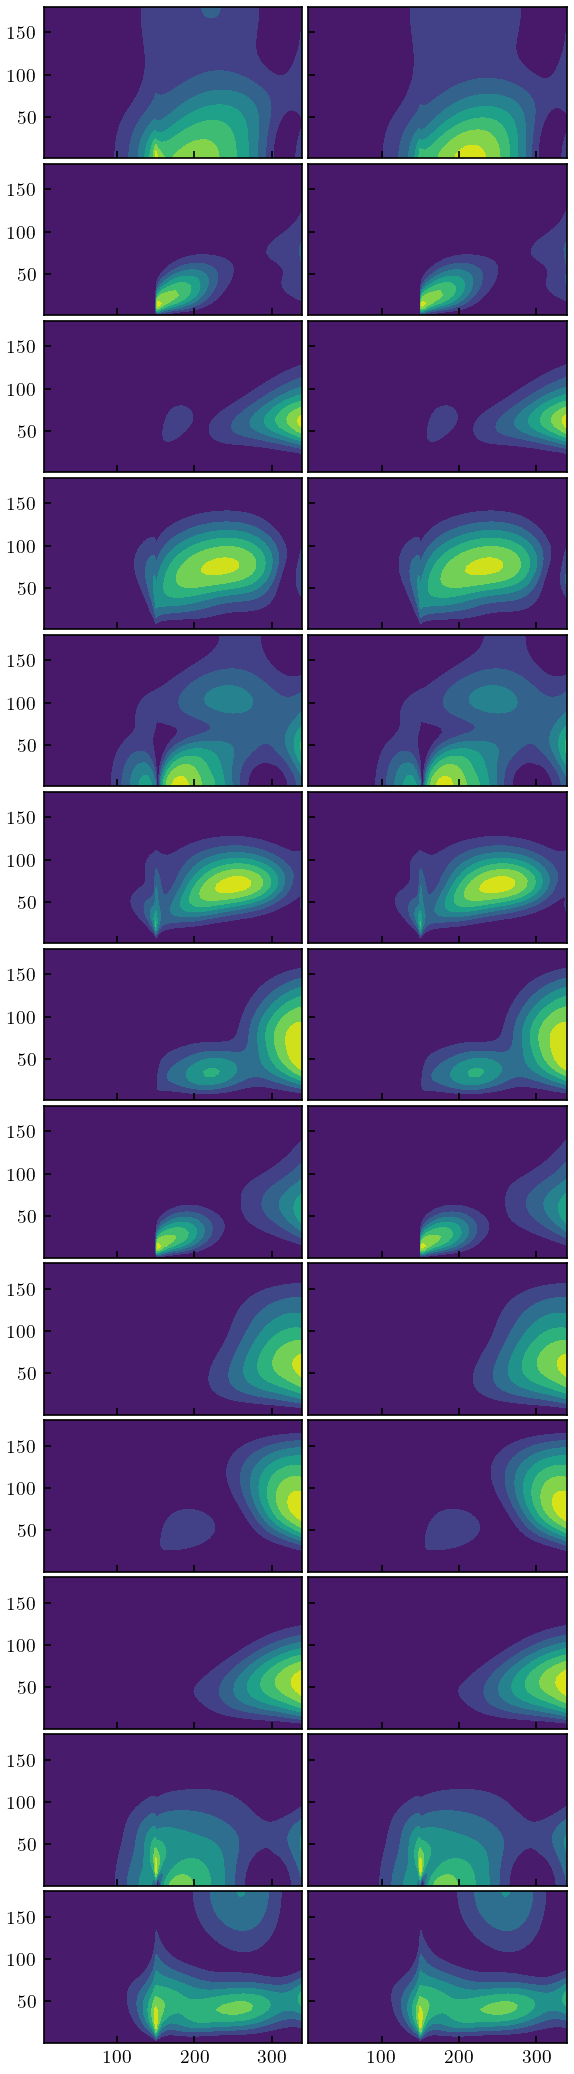

In [27]:
fig, axes = plt.subplots(len(observables_unique), 2, figsize=(4, 14), sharex=True, sharey=True)
for i, obs_i in enumerate(observables_unique):
    for j, nucleon_j in enumerate(['proton']):
        ax = axes[i, j]
        order_i = 4
#         compton_i = compton_obs[obs_i, nucleon_j, order_i, 'linear']
#         compton_mapped_i = compton_obs_mapped[obs_i, nucleon_j, order_i, 'linear']

#         util_i = np.zeros(data_combs.shape, dtype=float)
#         util_i_mapped = np.zeros(data_combs.shape, dtype=float)
#         for k, idx_k in enumerate(data_combs):
#             util_i[k] = compton_i.utility_linear(idx_k)
#             util_i_mapped[k] = compton_mapped_i.utility_linear(idx_k)
        util_i = utils_no_trans[nucleon_j, obs_i, 'all']
        util_i_mapped = utils_with_trans[nucleon_j, obs_i, 'all']

        axes[i, 0].contourf(omega_lab_unique, degrees_lab_unique, util_i.reshape(n_omega, n_angle).T)
        axes[i, 1].contourf(omega_lab_unique, degrees_lab_unique, util_i_mapped.reshape(n_omega, n_angle).T)
        axes[i, 0].tick_params(direction='in')
        axes[i, 1].tick_params(direction='in')
fig.tight_layout(h_pad=0.3, w_pad=0.3)

## Check subsets of polarizabilities

In [28]:
subset_names = ['all', r'$\alpha+\beta$', r'$\alpha-\beta$', r'$\gamma_i$']
subset_idxs = [
    [0, 1, 2, 3, 4, 5],
    [0],
    [1],
    [2, 3, 4, 5],
]
savenames = [
    'all',
    'amb',
    'apb',
    'gammas'
]
# subsets = {'all': [0, 1, 2, 3, 4, 5], r'$\alpha+\beta$': [0], r'$\alpha-\beta$': [1], r'$\gamma_i$s': [2, 3, 4, 5]}
subsets = {name: idx for name, idx in zip(subset_names, subset_idxs)}
subset_savenames = {name: savename for name, savename in zip(subset_names, savenames)}

nucleons = ['proton', 'neutron']

In [29]:
observables_unique

array(['$\\sigma$', '$\\Sigma_{1x}$', '$\\Sigma_{1z}$', '$\\Sigma_{2x}$',
       '$\\Sigma_{2z}$', '$\\Sigma_{3}$', '$\\Sigma_{y}$',
       '$\\Sigma_{3y}$', "$\\Sigma_{3y'}$", "$\\Sigma_{1x'}$",
       "$\\Sigma_{1z'}$", "$\\Sigma_{2x'}$", "$\\Sigma_{2z'}$"],
      dtype=object)

In [30]:
############
# Proton
############

proton_cov_cbars = {
    'dsg': 1.0,
    '1X': 1.0,
    '1Z': 1.0,
    '2X': 1.0,
    '2Z': 1.0,
    '3': 1.0,
    'Y': 1.0,
    '3Y': 1.0,
    '3Yp': 1.0,
    '1Xp': 1.0,
    '1Zp': 1.0,
    '2Xp': 1.0,
    '2Zp': 1.0,
}

proton_cov_length_scale_omega = {
    'dsg': 50.0,
    '1X': 50.0,
    '1Z': 50.0,
    '2X': 50.0,
    '2Z': 50.0,
    '3': 50.0,
    'Y': 50.0,
    '3Y': 50.0,
    '3Yp': 50.0,
    '1Xp': 50.0,
    '1Zp': 50.0,
    '2Xp': 50.0,
    '2Zp': 50.0,
}

proton_cov_length_scale_degrees = {
    'dsg': 20.0,
    '1X': 20.0,
    '1Z': 20.0,
    '2X': 20.0,
    '2Z': 20.0,
    '3': 20.0,
    'Y': 20.0,
    '3Y': 20.0,
    '3Yp': 20.0,
    '1Xp': 20.0,
    '1Zp': 20.0,
    '2Xp': 20.0,
    '2Zp': 20.0,
}


############
# Neutron
############

neutron_cov_cbars = {
    'dsg': 1.0,
    '1X': 1.0,
    '1Z': 1.0,
    '2X': 1.0,
    '2Z': 1.0,
    '3': 1.0,
    'Y': 1.0,
    '3Y': 1.0,
    '3Yp': 1.0,
    '1Xp': 1.0,
    '1Zp': 1.0,
    '2Xp': 1.0,
    '2Zp': 1.0,
}

neutron_cov_length_scale_omega = {
    'dsg': 50.0,
    '1X': 50.0,
    '1Z': 50.0,
    '2X': 50.0,
    '2Z': 50.0,
    '3': 50.0,
    'Y': 50.0,
    '3Y': 50.0,
    '3Yp': 50.0,
    '1Xp': 50.0,
    '1Zp': 50.0,
    '2Xp': 50.0,
    '2Zp': 50.0,
}

neutron_cov_length_scale_degrees = {
    'dsg': 20.0,
    '1X': 20.0,
    '1Z': 20.0,
    '2X': 20.0,
    '2Z': 20.0,
    '3': 20.0,
    'Y': 20.0,
    '3Y': 20.0,
    '3Yp': 20.0,
    '1Xp': 20.0,
    '1Zp': 20.0,
    '2Xp': 20.0,
    '2Zp': 20.0,
}

In [31]:
from compton import RBFJump, expansion_parameter_transfer_cm, mass_proton, order_transition

breakdown = 650
# Fourth order is complete at low energy, so omitted is 5
# But it is not complete at high energy, so it goes to 2
# No, it actually goes to 1!
# omitted_order = order_transition(5, 2, X[:, 0])
omitted_order = order_transition(5, 1, X[:, 0])

# Q becomes greater than one... need a better definition
Q = expansion_parameter_transfer_cm(X, breakdown, mass=mass_proton)

Q_sum = np.zeros((Q.shape[0], Q.shape[0]))
for i in range(100):
    Qi = Q**(omitted_order+i)
    Q_sum += Qi[:, None] * Qi

# Qmat = Q[:, None] * Q
# Q_sum = Qmat**omitted_order / (1 - Qmat)

corr_mat = np.eye(Q.shape[0])
R_mat = Q_sum * corr_mat

cov_trunc = sd_exp**2 * np.eye(len(X)) + R_mat

In [32]:
Q.max()

1.0088964525253628

In [33]:
cov_p_proton_trans = np.diag(proton_pol_vec_trans_std)
cov_p_neutron_trans = np.diag(neutron_pol_vec_trans_std)  # Need real values for this!!!
compton_obs_trans = create_observable_set(
    df=df, cov_exp=sd_exp**2, p_transform=P, cov_p_proton=cov_p_proton_trans, cov_p_neutron=cov_p_neutron_trans
)
compton_obs_trans_trunc = create_observable_set(
    df=df, cov_exp=cov_trunc, p_transform=P, cov_p_proton=cov_p_proton_trans, cov_p_neutron=cov_p_neutron_trans
)

In [34]:
# compton_obs_trans_trunc['2Xp', 'neutron', 3, 'linear'].omega_lab

## No Truncation Error

In [35]:
util_dict_trans_sets = compute_all_1pt_utilities(compton_obs_trans, subsets)

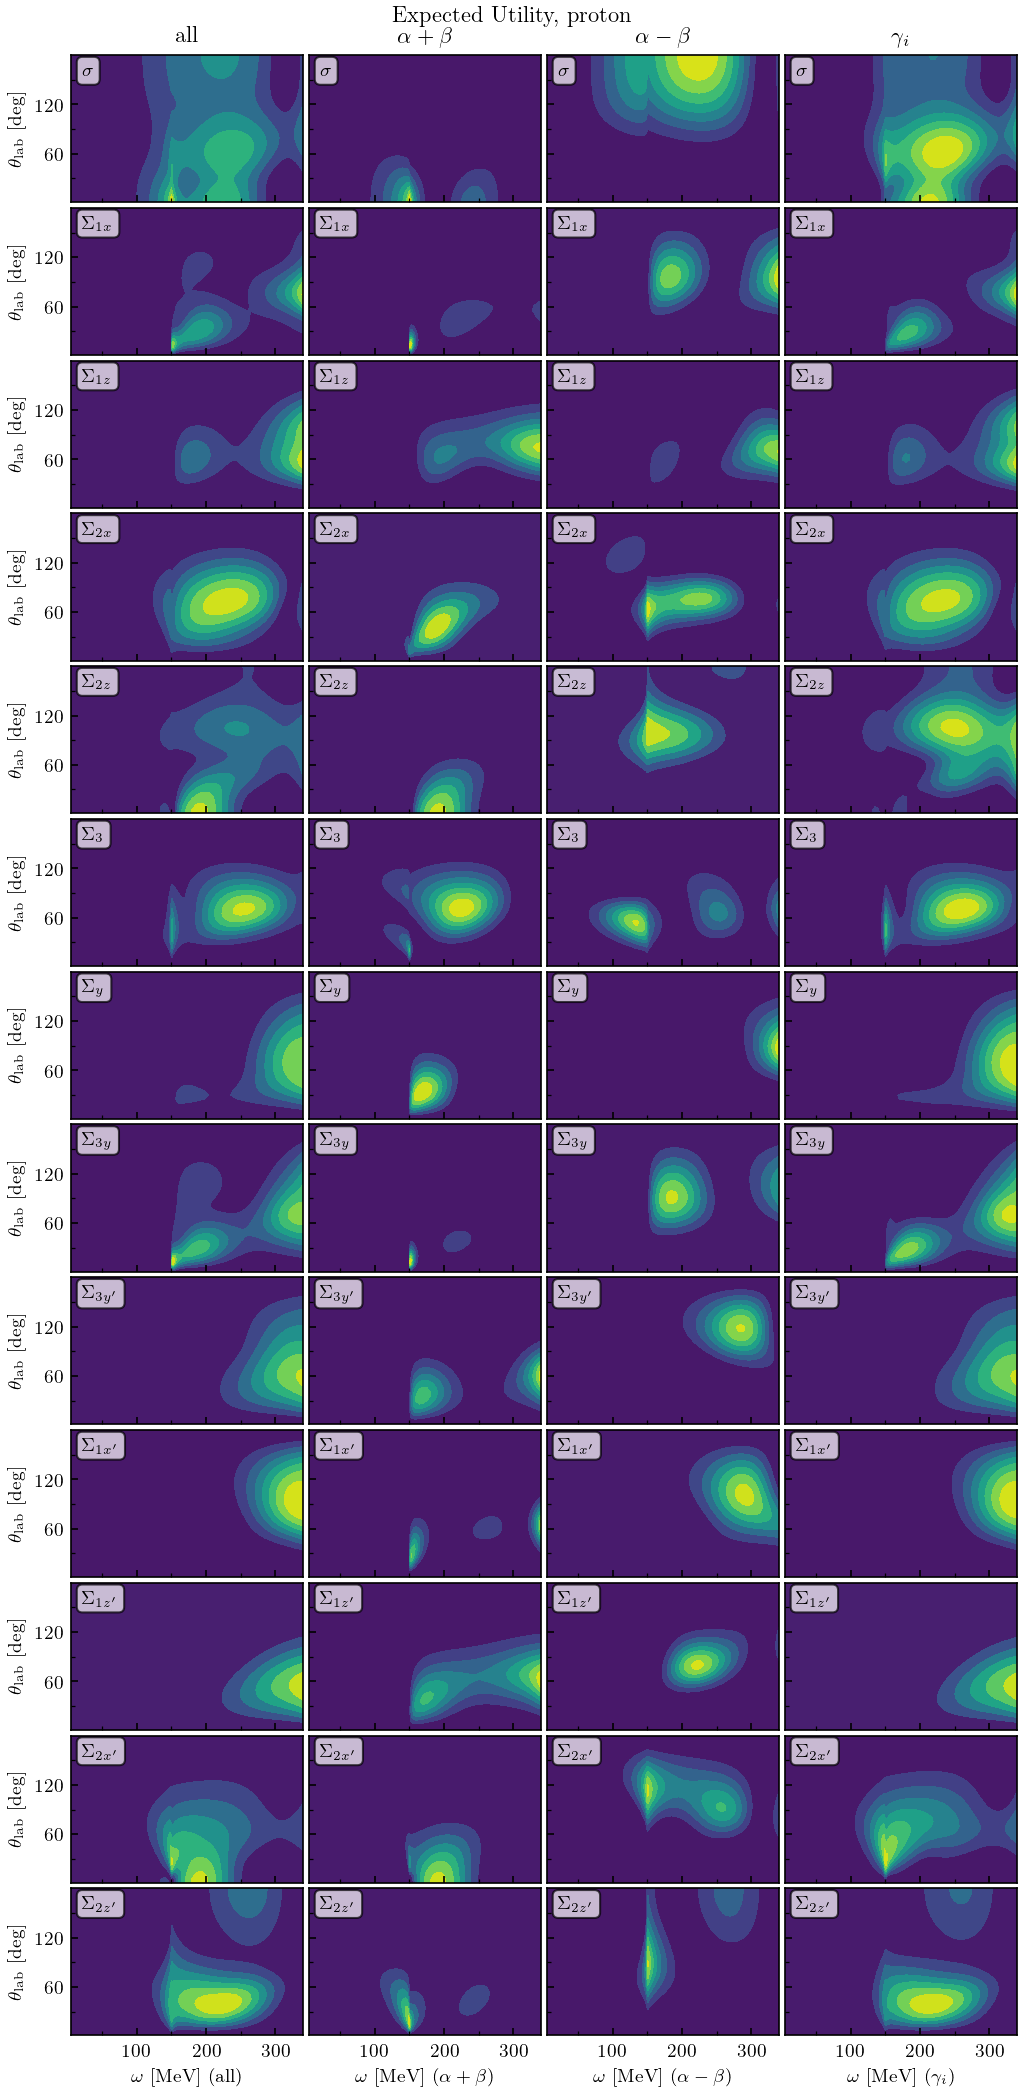

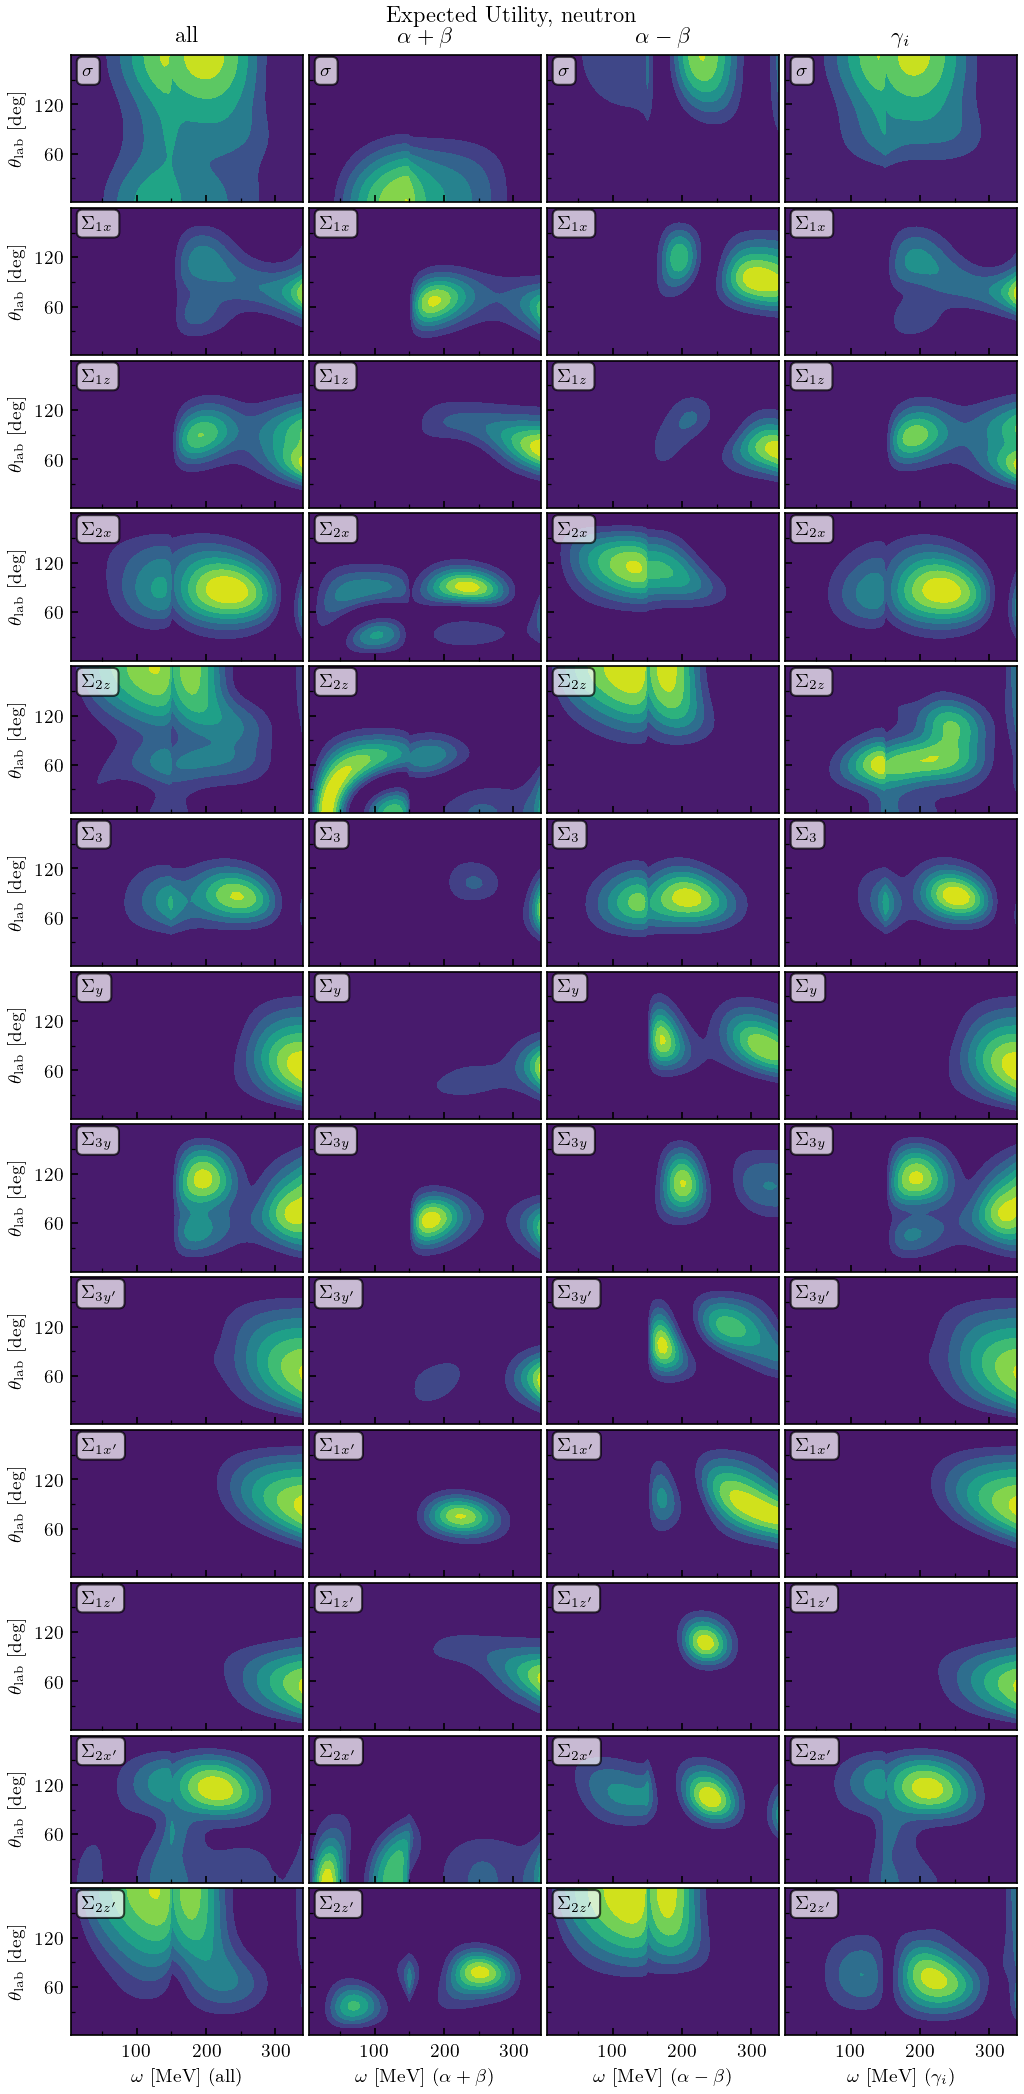

In [36]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    for nucleon in nucleons:
        fig, axes = plot_subsets(
            util_dict_trans_sets, nucleon, omega_lab_unique, degrees_lab_unique,
            observables=observables_unique, subsets=subset_names)
        fig.suptitle(f'Expected Utility, {nucleon}', y=1)
        fig.tight_layout(h_pad=0.3, w_pad=0.3)
        plt.show()
        fig.savefig(f'figures/utility_{nucleon}_subsets_transformed.pdf')

## Truncation Error

In [37]:
util_dict_trans_trunc_sets = compute_all_1pt_utilities(compton_obs_trans_trunc, subsets)

In [38]:
bests_1pt_trunc_dict = compute_max_utilities(
    compton_obs_trans_trunc, subsets, omega_lab_unique, degrees_lab_unique, n_degrees=1
)

all
0
$\alpha+\beta$
0
$\alpha-\beta$
0
$\gamma_i$
0
all
0
$\alpha+\beta$
0
$\alpha-\beta$
0
$\gamma_i$
0


In [39]:
df_bests_1pt_trunc = convert_max_utilities_to_flat_dataframe(bests_1pt_trunc_dict)

In [40]:
df_bests_1pt_trunc

,idx,omega,theta,nucleon,observable,util,subset,shrinkage
0,185,30.0,1,neutron,$\Sigma_{2z}$,0.078630,$\alpha+\beta$,1.081804
1,185,30.0,1,neutron,$\Sigma_{2x'}$,0.078604,$\alpha+\beta$,1.081776
2,488,70.0,35,neutron,$\Sigma_{2z'}$,0.010468,$\alpha+\beta$,1.010523
3,628,85.0,180,neutron,$\sigma$,0.058864,$\alpha-\beta$,1.060631
4,628,85.0,180,neutron,$\Sigma_{2z}$,0.421174,$\alpha-\beta$,1.523749
...,...,...,...,...,...,...,...,...
99,1490,175.0,50,proton,$\Sigma_{3y'}$,0.011147,$\gamma_i$,1.011209
100,1529,180.0,60,proton,$\Sigma_{1z'}$,0.000007,$\alpha-\beta$,1.000007
101,2710,340.0,45,proton,$\Sigma_{1z'}$,0.008430,$\gamma_i$,1.008465
102,2710,340.0,45,neutron,$\Sigma_{1z'}$,0.010178,all,1.010230


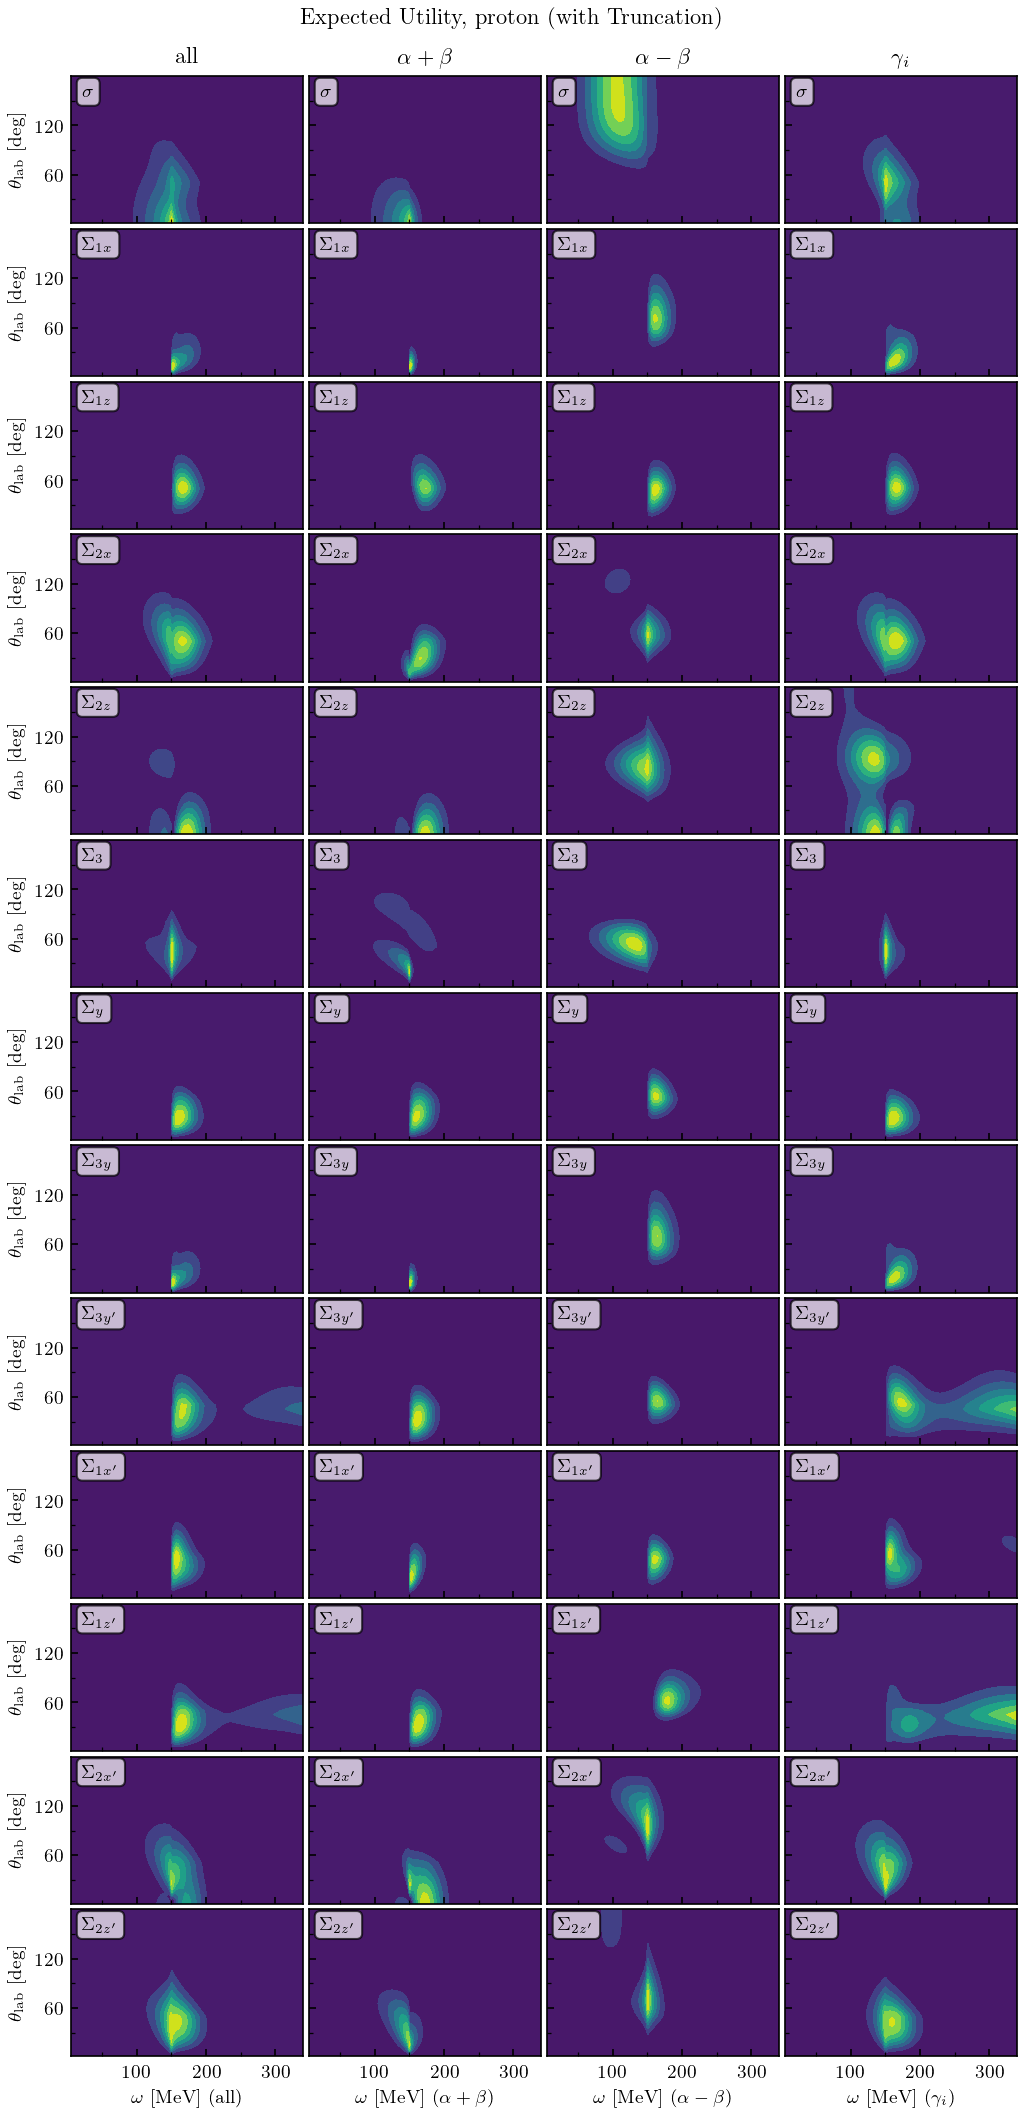

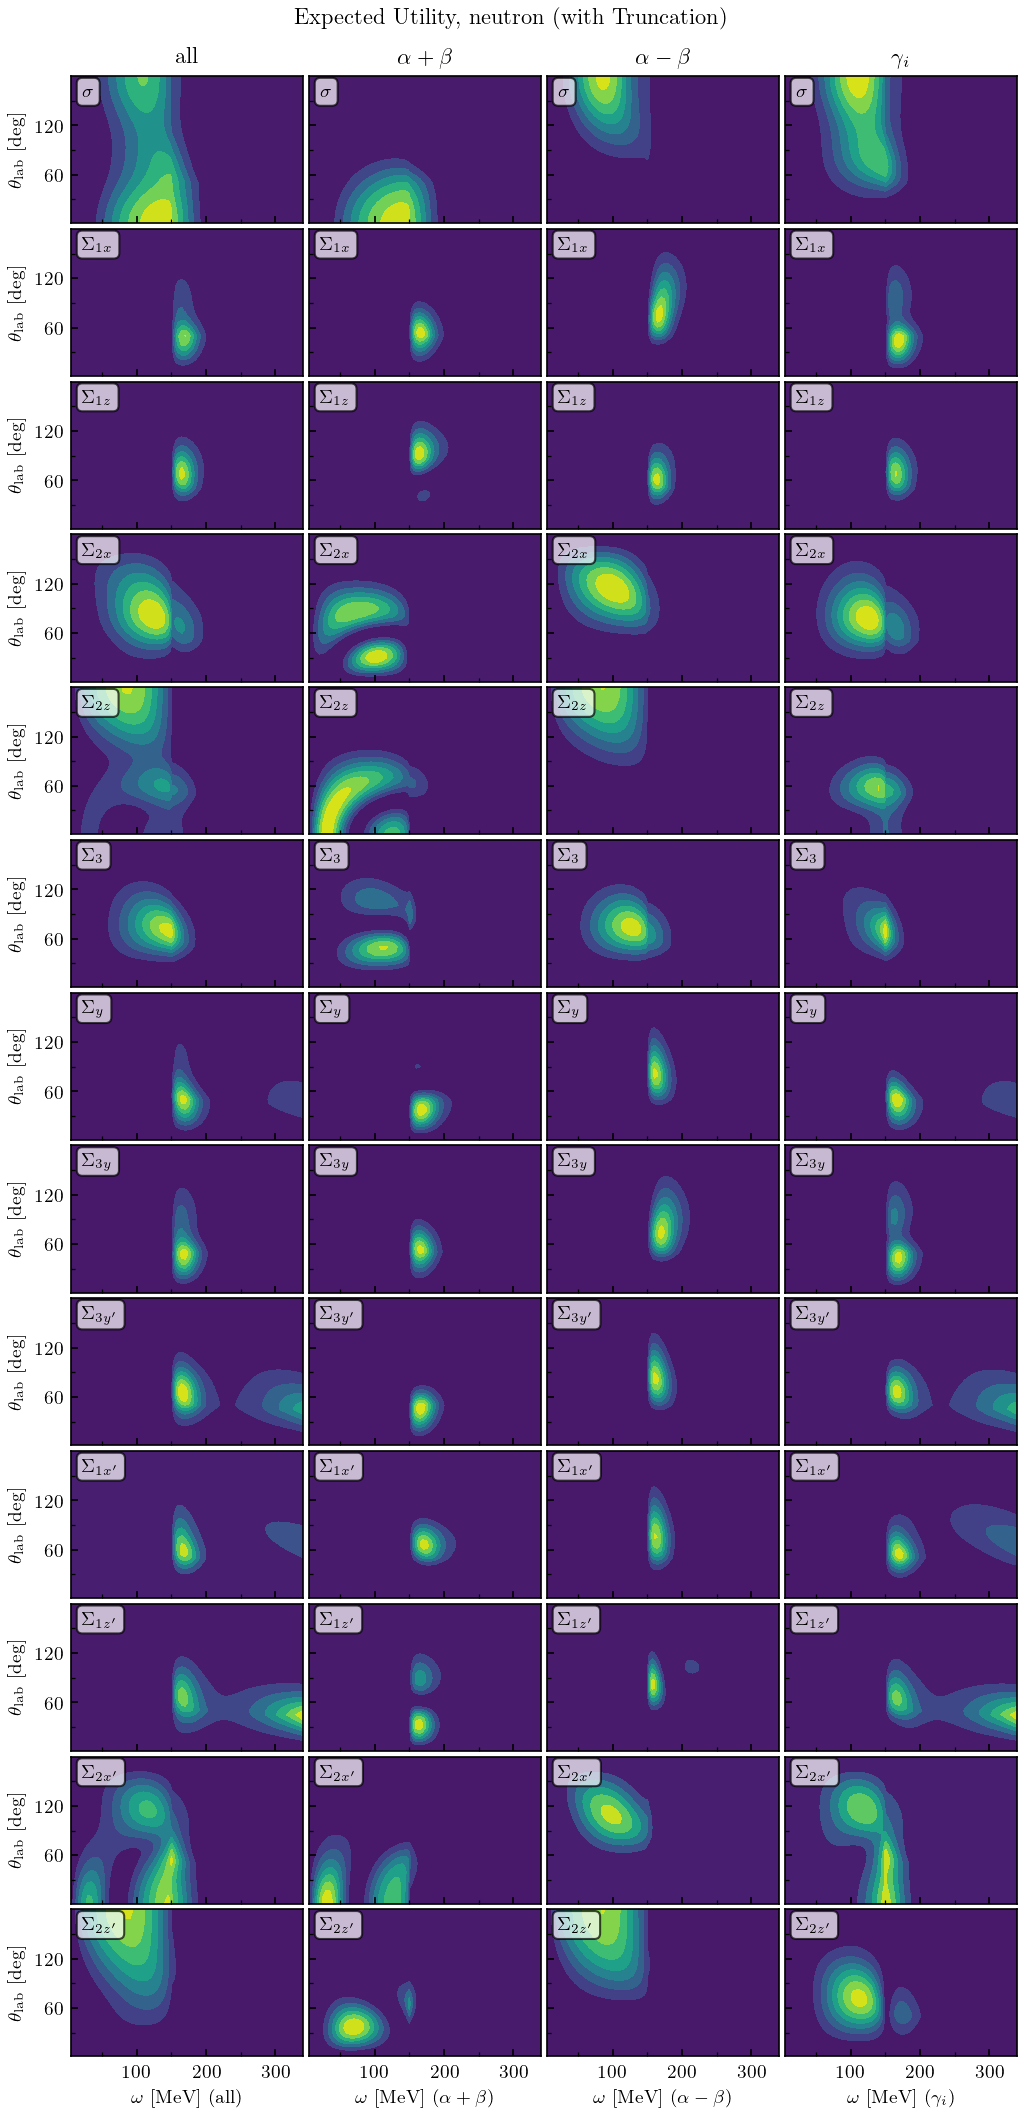

In [41]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    for nucleon in nucleons:
        fig, axes = plot_subsets(
            util_dict_trans_trunc_sets, nucleon, omega_lab_unique, degrees_lab_unique,
            observables=observables_unique, subsets=subset_names)
        fig.suptitle(f'Expected Utility, {nucleon} (with Truncation)', y=1.01)
        fig.tight_layout(h_pad=0.3, w_pad=0.3)
        plt.show()
        fig.savefig(f'figures/utility_{nucleon}_subsets_transformed_trunc.pdf')

In [42]:
from compton import plot_comparison_subsets_and_truncation

In [43]:
# df_bests_1pt_trunc = pd.DataFrame.from_dict(util_dict_trans_trunc_sets_bests).T
# df_bests_1pt_trunc.index.names = 'observable', 'subset'
# df_bests_1pt_trunc = df_bests_1pt_trunc.reset_index()
# df_bests_1pt_trunc['idx'] = df_bests_1pt_trunc.astype({'idx': 'int32'})['idx']
# df_bests_1pt_trunc['shrinkage'] = np.exp(df_bests_1pt_trunc['util'])
# df_bests_1pt_trunc

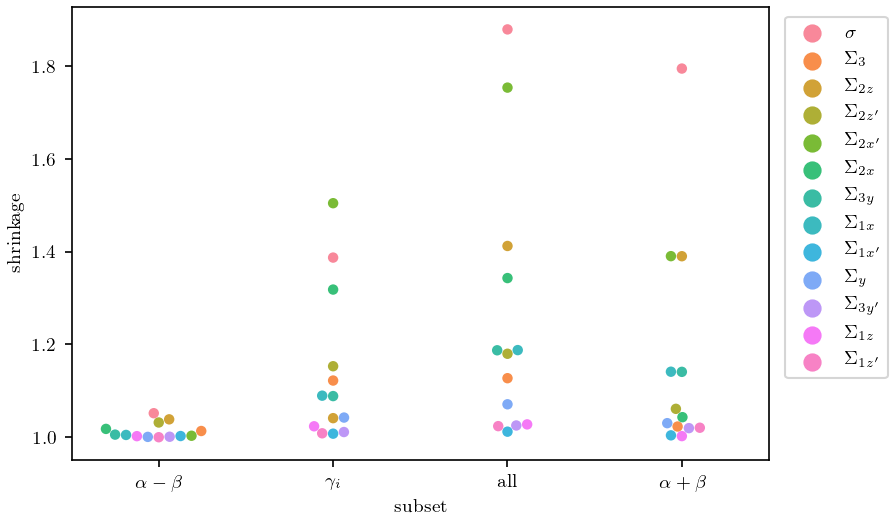

In [44]:
sns.swarmplot(
    x='subset', y='shrinkage', data=df_bests_1pt_trunc[df_bests_1pt_trunc['nucleon'] == 'proton'],
    hue='observable', #marker=list(df_bests_1pt_trunc['observable'].values)
)
plt.legend().set_bbox_to_anchor((1.01, 1))

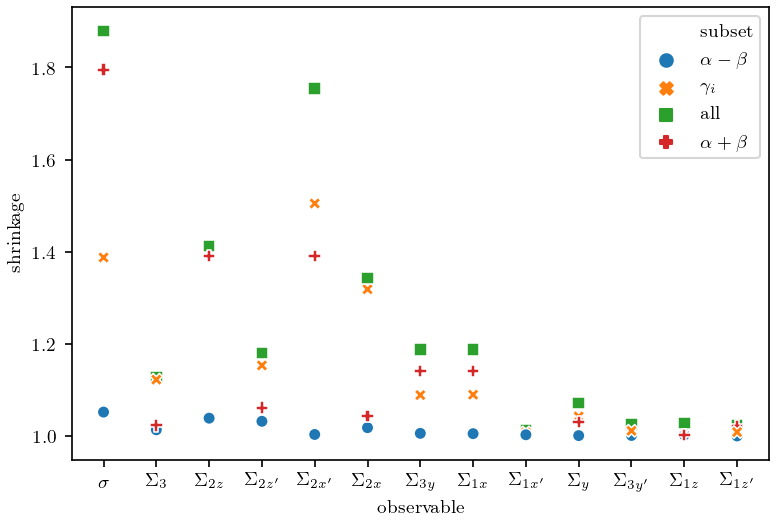

In [45]:
sns.scatterplot(
    x='observable', y='shrinkage', data=df_bests_1pt_trunc[df_bests_1pt_trunc['nucleon'] == 'proton'],
    hue='subset',
    style='subset'
)

In [46]:
util_dict_trans_trunc_sets

{('neutron',
  "$\\Sigma_{1x'}$",
  'all'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.90809783e-07, 6.31743834e-08, 0.00000000e+00]),
 ('proton',
  "$\\Sigma_{1x'}$",
  'all'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.94337997e-07, 8.73888193e-08, 0.00000000e+00]),
 ('neutron',
  "$\\Sigma_{1x'}$",
  '$\\alpha+\\beta$'): array([0., 0., 0., ..., 0., 0., 0.]),
 ('proton',
  "$\\Sigma_{1x'}$",
  '$\\alpha+\\beta$'): array([0., 0., 0., ..., 0., 0., 0.]),
 ('neutron',
  "$\\Sigma_{1x'}$",
  '$\\alpha-\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.53661803e-10, 9.44924139e-11, 0.00000000e+00]),
 ('proton',
  "$\\Sigma_{1x'}$",
  '$\\alpha-\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.60632488e-11, 4.76058776e-12, 0.00000000e+00]),
 ('neutron',
  "$\\Sigma_{1x'}$",
  '$\\gamma_i$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.90356122e-07, 6.3

In [47]:
# /.

In [48]:
X_reduced = X[(X[:, 1] > 30) & (X[:, 1] < 150) & (X[:, 0] > 50)]
X_reduced = X_reduced[(X_reduced[:, 0] % 2 == 0) & (X_reduced[:, 1] % 2 == 0)]
omega_lab_reduced_unique = np.unique(X_reduced[:, 0])
degrees_lab_reduced_unique = np.unique(X_reduced[:, 1])

In [49]:
X_reduced

array([[ 60.,  40.],
       [ 60.,  50.],
       [ 60.,  60.],
       [ 60.,  70.],
       [ 60.,  80.],
       [ 60.,  90.],
       [ 60., 100.],
       [ 60., 110.],
       [ 60., 120.],
       [ 60., 130.],
       [ 60., 140.],
       [ 70.,  40.],
       [ 70.,  50.],
       [ 70.,  60.],
       [ 70.,  70.],
       [ 70.,  80.],
       [ 70.,  90.],
       [ 70., 100.],
       [ 70., 110.],
       [ 70., 120.],
       [ 70., 130.],
       [ 70., 140.],
       [ 80.,  40.],
       [ 80.,  50.],
       [ 80.,  60.],
       [ 80.,  70.],
       [ 80.,  80.],
       [ 80.,  90.],
       [ 80., 100.],
       [ 80., 110.],
       [ 80., 120.],
       [ 80., 130.],
       [ 80., 140.],
       [ 90.,  40.],
       [ 90.,  50.],
       [ 90.,  60.],
       [ 90.,  70.],
       [ 90.,  80.],
       [ 90.,  90.],
       [ 90., 100.],
       [ 90., 110.],
       [ 90., 120.],
       [ 90., 130.],
       [ 90., 140.],
       [100.,  40.],
       [100.,  50.],
       [100.,  60.],
       [100.,

In [50]:
len(X_reduced)

330

In [51]:
degrees_lab_reduced_unique

array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.])

In [52]:
omega_lab_reduced_unique

array([ 60.,  70.,  80.,  90., 100., 110., 120., 130., 140., 148., 152.,
       160., 170., 180., 190., 200., 210., 220., 230., 240., 250., 260.,
       270., 280., 290., 300., 310., 320., 330., 340.])

In [53]:
from compton import plot_observables_true_vs_linearized, neutron_pol_vec_mean, neutron_pol_vec_std

In [224]:
n_pol_samples = 1000

np.random.seed(1)

proton_pol_trans_samples = stats.norm(
    loc=proton_pol_vec_trans_mean, scale=proton_pol_vec_trans_std
).rvs((n_pol_samples, len(proton_pol_vec_trans_mean)))
neutron_pol_trans_samples = stats.norm(
    loc=neutron_pol_vec_trans_mean, scale=neutron_pol_vec_trans_std
).rvs((n_pol_samples, len(neutron_pol_vec_trans_mean)))


proton_pol_samples = stats.norm(
    loc=proton_pol_vec_mean, scale=proton_pol_vec_std
).rvs((n_pol_samples, len(proton_pol_vec_mean)))
neutron_pol_samples = stats.norm(
    loc=neutron_pol_vec_mean, scale=neutron_pol_vec_std
).rvs((n_pol_samples, len(neutron_pol_vec_mean)))

In [225]:
proton_pol_trans_samples.shape

(1000, 6)

In [226]:
observables_unique

array(['$\\sigma$', '$\\Sigma_{1x}$', '$\\Sigma_{1z}$', '$\\Sigma_{2x}$',
       '$\\Sigma_{2z}$', '$\\Sigma_{3}$', '$\\Sigma_{y}$',
       '$\\Sigma_{3y}$', "$\\Sigma_{3y'}$", "$\\Sigma_{1x'}$",
       "$\\Sigma_{1z'}$", "$\\Sigma_{2x'}$", "$\\Sigma_{2z'}$"],
      dtype=object)

In [227]:
omega_lab_reduced_unique

array([ 60.,  70.,  80.,  90., 100., 110., 120., 130., 140., 148., 152.,
       160., 170., 180., 190., 200., 210., 220., 230., 240., 250., 260.,
       270., 280., 290., 300., 310., 320., 330., 340.])

In [228]:
degrees_lab_reduced_unique

array([ 40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.])

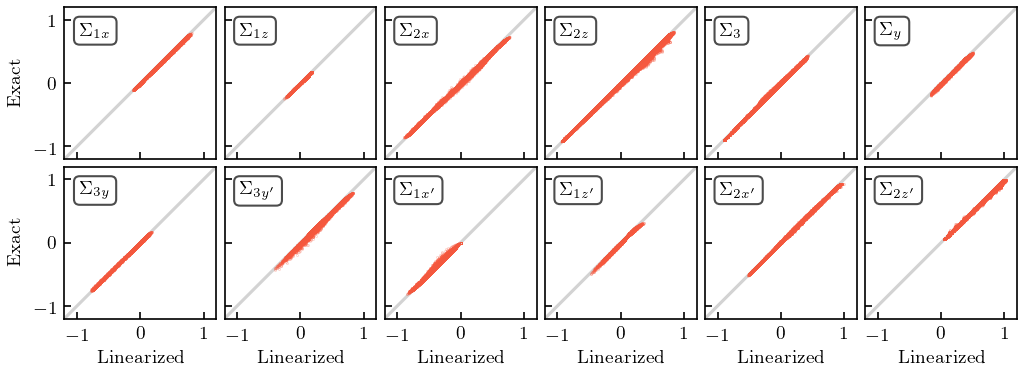

In [229]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plot_observables_true_vs_linearized(
        compton_obs_trans, proton_pol_trans_samples, nucleon='proton',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[1:], color=proton_color
    );
    fig.savefig('spin_observables_true_vs_linearized_proton_trans')
    plt.show()

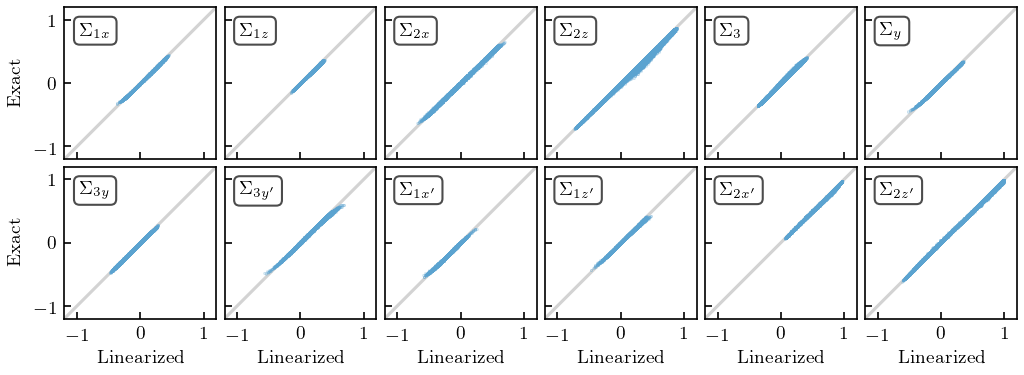

In [230]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plot_observables_true_vs_linearized(
        compton_obs_trans, neutron_pol_trans_samples, nucleon='neutron',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[1:], color=neutron_color
    );
    fig.savefig('spin_observables_true_vs_linearized_neutron_trans')
    plt.show()

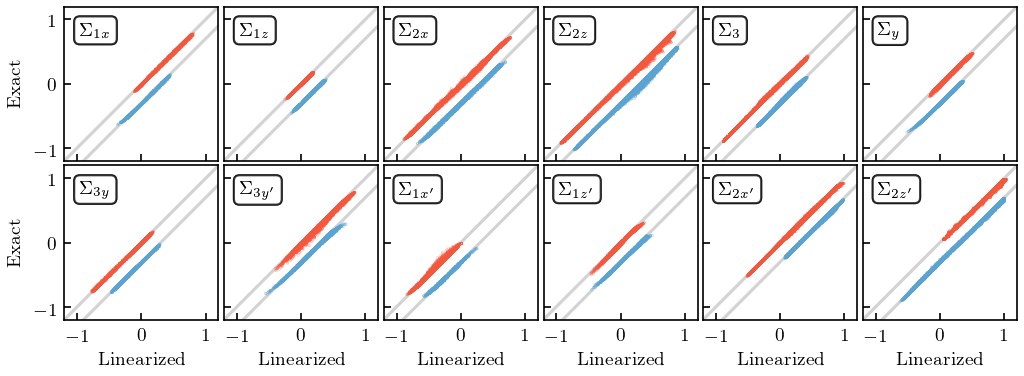

In [231]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plot_observables_true_vs_linearized(
        compton_obs_trans, proton_pol_trans_samples, nucleon='proton',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[1:], color=proton_color
    );
    plot_observables_true_vs_linearized(
        compton_obs_trans, neutron_pol_trans_samples, nucleon='neutron',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[1:], color=neutron_color, offset=0.3, axes=axes
    );
    fig.savefig('spin_observables_true_vs_linearized_both_trans')
    plt.show()

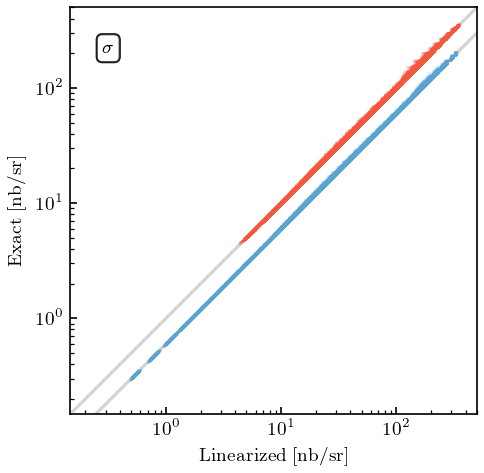

In [232]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
    axes = np.atleast_2d(ax)
    fig, axes = plot_observables_true_vs_linearized(
        compton_obs_trans, proton_pol_trans_samples, nucleon='proton',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[[0]], color=proton_color, axes=axes
    );
    plot_observables_true_vs_linearized(
        compton_obs_trans, neutron_pol_trans_samples, nucleon='neutron',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[[0]], color=neutron_color, offset=0.6, axes=axes
    );
    fig.savefig('dsg_true_vs_linearized_both_trans')
    plt.show()

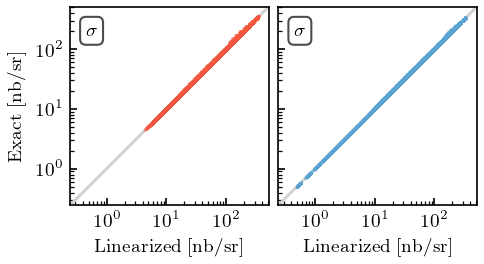

In [233]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plt.subplots(1, 2, figsize=(3.4, 5), sharex=True, sharey=True)
    fig, _ = plot_observables_true_vs_linearized(
        compton_obs_trans, proton_pol_trans_samples, nucleon='proton',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[[0]], color=proton_color, axes=axes[[0]]
    );
    plot_observables_true_vs_linearized(
        compton_obs_trans, neutron_pol_trans_samples, nucleon='neutron',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[[0]], color=neutron_color, axes=axes[[1]]
    );
    axes[1].set_ylabel('')
    xlim = axes[1].get_xlim()
    axes[1].set_xticks(axes[0].get_yticks(minor=True), minor=True)
    axes[1].set_xticks(axes[0].get_yticks(minor=False), minor=False)
    axes[1].set_xlim(xlim)
    fig.tight_layout(w_pad=0.5)
    fig.savefig('dsg_true_vs_linearized_both_trans2')
    plt.show()

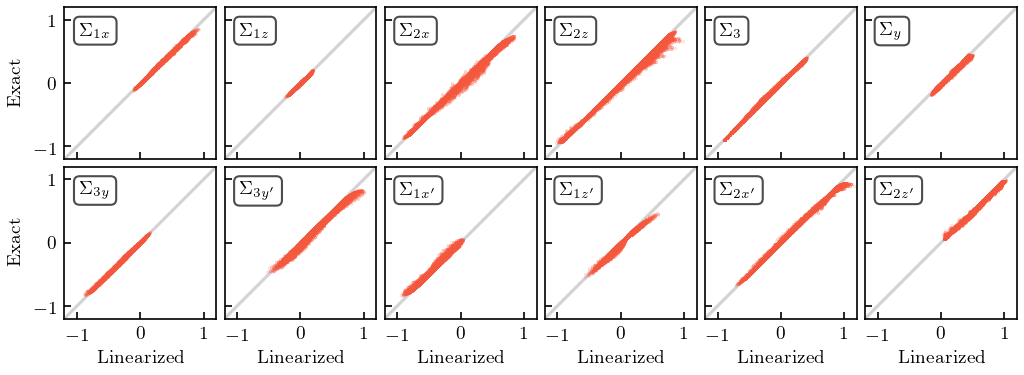

In [234]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plot_observables_true_vs_linearized(
        compton_obs, proton_pol_samples, nucleon='proton',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[1:], color=proton_color
    );
    fig.savefig('spin_observables_true_vs_linearized_proton')
    plt.show()

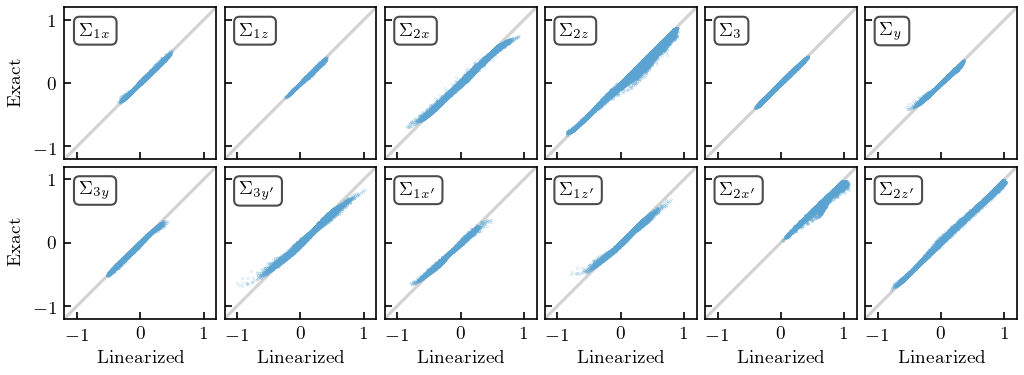

In [235]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plot_observables_true_vs_linearized(
        compton_obs, neutron_pol_samples, nucleon='neutron',
        omega=omega_lab_reduced_unique, degrees=degrees_lab_reduced_unique,
        observables=observables_unique[1:], color=neutron_color
    );
    fig.savefig('spin_observables_true_vs_linearized_neutron')
    plt.show()

In [63]:
n_angle_search = 5

bests_npt_trunc_dict = compute_max_utilities(
    compton_obs_trans_trunc, subsets, omega_lab_reduced_unique, degrees_lab_reduced_unique, n_degrees=n_angle_search
)


# # best_util = -np.inf
# # best_idxs = None
# # best_obs = None
# # subset_name = 'all'
# # subset_name = r'$\alpha-\beta$'
# # subset = subsets[subset_name]

# util_bests_npts = {}



# for subset_name, subset in subsets.items():
#     bests = {obs: dict(util=-np.inf) for obs in observables_unique}
#     print(subset_name)
#     for aa, angles in enumerate(combinations(degrees_lab_reduced_unique, n_angle_search)):
#         if aa % 100 == 0:
#             print(aa)
#         for energy in omega_lab_reduced_unique:
#             for obs_i in observables_unique:
#     #             idxs = np.where((X_reduced[:, 0] == energy) & np.isin(X_reduced[:, 1], angles))[0]
#                 # The observable object is set up to only know about X
#                 idxs = np.where((X[:, 0] == energy) & np.isin(X[:, 1], angles))[0]
#                 order_i = 4
#                 compton_i = compton_obs_trans_trunc[obs_i, 'proton', order_i, 'linear']
#                 current_util = compton_i.utility_linear(idxs, p_idx=subset, only_log=False)
#                 if current_util > bests[obs_i]['util']:
#                     bests_i = bests[obs_i]
#                     bests_i['util'] = current_util
#                     bests_i['idxs'] = idxs
#                     bests_i['omega'] = X[idxs, 0]
#                     bests_i['theta'] = X[idxs, 1]
#                     util_bests_npts[obs_i, subset_name] = bests_i

# print(bests)
# print(util_bests_npts)
# # print(best_idxs)

all
0
100
200
300
400
$\alpha+\beta$
0
100
200
300
400
$\alpha-\beta$
0
100
200
300
400
$\gamma_i$
0
100
200
300
400
all
0
100
200
300
400
$\alpha+\beta$
0
100
200
300
400
$\alpha-\beta$
0
100
200
300
400
$\gamma_i$
0
100
200
300
400


In [64]:
df_bests_npt_trunc = convert_max_utilities_to_dataframe(bests_npt_trunc_dict, observable_order=observables_unique)
df_bests_npt_trunc_flat = convert_max_utilities_to_flat_dataframe(bests_npt_trunc_dict, observable_order=observables_unique)
df_bests_npt_trunc['n pts'] = n_angle_search

In [65]:
df_bests_npt_trunc

,nucleon,observable,subset,util,idxs,omega,theta,shrinkage,n pts
0,neutron,$\Sigma_{1x'}$,all,0.030174,"[1451, 1453, 1455, 1457, 1459]","[170.0, 170.0, 170.0, 170.0, 170.0]","[40, 50, 60, 70, 80]",1.030634,5
1,neutron,$\Sigma_{1x}$,all,0.149549,"[1451, 1453, 1455, 1457, 1459]","[170.0, 170.0, 170.0, 170.0, 170.0]","[40, 50, 60, 70, 80]",1.161311,5
2,neutron,$\Sigma_{1z'}$,all,0.033435,"[1453, 1455, 1457, 1459, 1461]","[170.0, 170.0, 170.0, 170.0, 170.0]","[50, 60, 70, 80, 90]",1.034000,5
3,neutron,$\Sigma_{1z}$,all,0.089707,"[1453, 1455, 1457, 1459, 1461]","[170.0, 170.0, 170.0, 170.0, 170.0]","[50, 60, 70, 80, 90]",1.093854,5
4,neutron,$\Sigma_{2x'}$,all,0.344561,"[1118, 1120, 1122, 1124, 1126]","[148.0, 148.0, 148.0, 148.0, 148.0]","[40, 50, 60, 70, 80]",1.411370,5
...,...,...,...,...,...,...,...,...,...
99,proton,$\Sigma_{3y'}$,$\gamma_i$,0.039910,"[1451, 1453, 1455, 1457, 1459]","[170.0, 170.0, 170.0, 170.0, 170.0]","[40, 50, 60, 70, 80]",1.040717,5
100,proton,$\Sigma_{3y}$,$\gamma_i$,0.076999,"[1451, 1453, 1455, 1457, 1459]","[170.0, 170.0, 170.0, 170.0, 170.0]","[40, 50, 60, 70, 80]",1.080041,5
101,proton,$\Sigma_{3}$,$\gamma_i$,0.284224,"[1266, 1268, 1270, 1272, 1274]","[152.0, 152.0, 152.0, 152.0, 152.0]","[40, 50, 60, 70, 80]",1.328730,5
102,proton,$\Sigma_{y}$,$\gamma_i$,0.057735,"[1377, 1379, 1381, 1383, 1385]","[160.0, 160.0, 160.0, 160.0, 160.0]","[40, 50, 60, 70, 80]",1.059434,5


In [66]:
bests_1pt_reduced_trunc_dict = compute_max_utilities(
    compton_obs_trans_trunc, subsets, omega_lab_reduced_unique, degrees_lab_reduced_unique, n_degrees=1
)
df_bests_1pt_reduced_trunc = convert_max_utilities_to_dataframe(bests_1pt_reduced_trunc_dict, observable_order=observables_unique)
df_bests_1pt_reduced_trunc_flat = convert_max_utilities_to_flat_dataframe(bests_1pt_reduced_trunc_dict, observable_order=observables_unique)
df_bests_1pt_reduced_trunc['n pts'] = 1

all
0
$\alpha+\beta$
0
$\alpha-\beta$
0
$\gamma_i$
0
all
0
$\alpha+\beta$
0
$\alpha-\beta$
0
$\gamma_i$
0


Find optimal points for the no-truncation error one too

In [67]:
bests_npt_dict = compute_max_utilities(
    compton_obs_trans, subsets, omega_lab_reduced_unique, degrees_lab_reduced_unique, n_degrees=n_angle_search
)

all
0
100
200
300
400
$\alpha+\beta$
0
100
200
300
400
$\alpha-\beta$
0
100
200
300
400
$\gamma_i$
0
100
200
300
400
all
0
100
200
300
400
$\alpha+\beta$
0
100
200
300
400
$\alpha-\beta$
0
100
200
300
400
$\gamma_i$
0
100
200
300
400


In [68]:
df_bests_npt = convert_max_utilities_to_dataframe(bests_npt_dict, observable_order=observables_unique)
df_bests_npt_flat = convert_max_utilities_to_flat_dataframe(bests_npt_dict, observable_order=observables_unique)
df_bests_npt['n pts'] = n_angle_search

In [69]:
bests_1pt_reduced_dict = compute_max_utilities(
    compton_obs_trans_trunc, subsets, omega_lab_reduced_unique, degrees_lab_reduced_unique, n_degrees=1
)
df_bests_1pt_trunc = convert_max_utilities_to_dataframe(bests_1pt_reduced_dict, observable_order=observables_unique)
df_bests_1pt_trunc_flat = convert_max_utilities_to_flat_dataframe(bests_1pt_reduced_dict, observable_order=observables_unique)
df_bests_1pt_trunc['n pts'] = 1

all
0
$\alpha+\beta$
0
$\alpha-\beta$
0
$\gamma_i$
0
all
0
$\alpha+\beta$
0
$\alpha-\beta$
0
$\gamma_i$
0


In [70]:
subset_names

['all', '$\\alpha+\\beta$', '$\\alpha-\\beta$', '$\\gamma_i$']

In [71]:
nucleon_cmaps = {'neutron': 'Blues', 'proton': 'Reds'}

Consider making the charts below using experimental noise as well. Could show all combinations with/without theory and with/without experiment, to show why they are both useful to include.

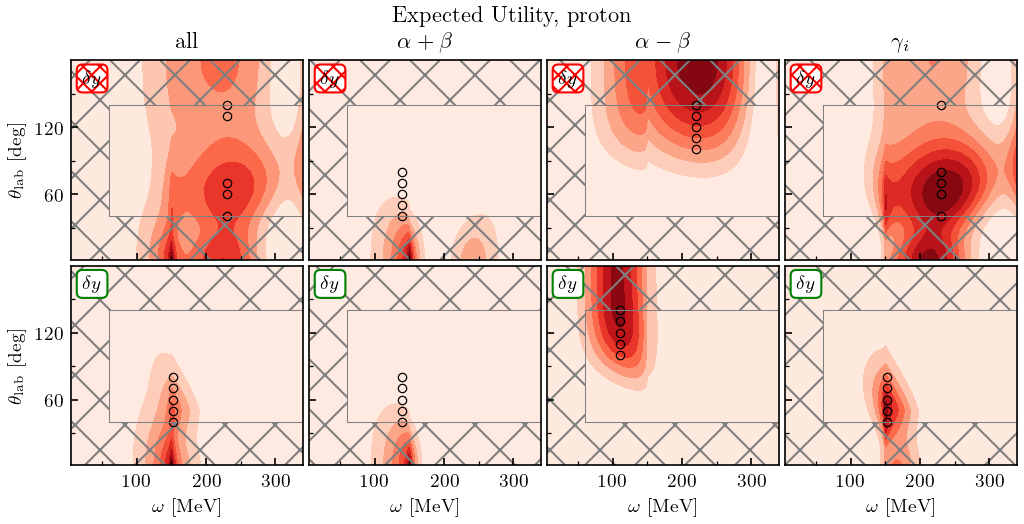

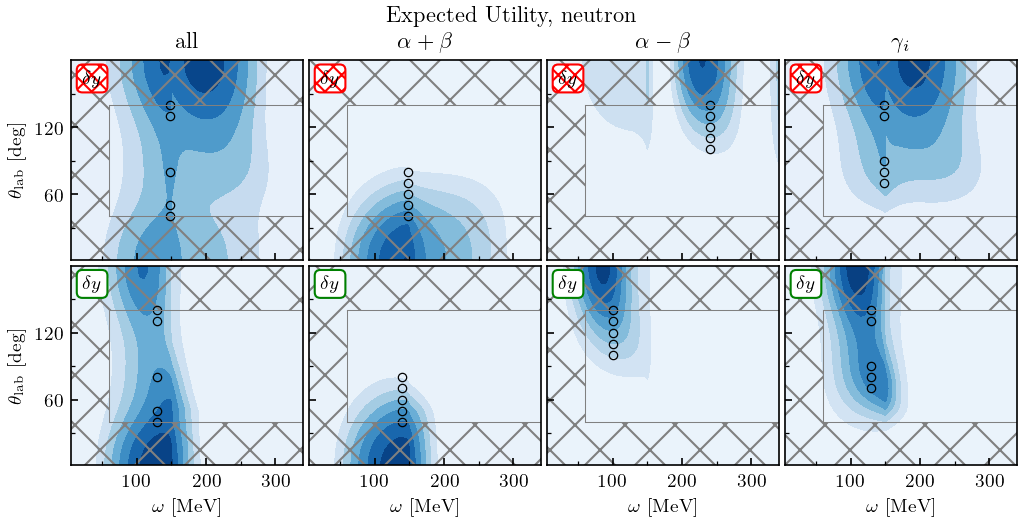

In [72]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    for nucleon in nucleons:
#         fig, axes = plot_subsets(
#             util_dict_trans_trunc_sets, nucleon, omega_lab_unique, degrees_lab_unique,
#             observables=observables_unique, subsets=subset_names)
        fig, axes = plot_comparison_subsets_and_truncation(
            util_dict_trans_sets, util_dict_trans_trunc_sets, nucleon=nucleon, observable=r'$\sigma$',
            max_util_dict_no_trunc=bests_npt_dict, max_util_dict_with_trunc=bests_npt_trunc_dict,
            omega=omega_lab_unique, degrees=degrees_lab_unique, subsets=subset_names,
            degrees_min=np.min(degrees_lab_reduced_unique), degrees_max=np.max(degrees_lab_reduced_unique),
            omega_min=np.min(omega_lab_reduced_unique),
            cmap=nucleon_cmaps[nucleon],
        )
        fig.suptitle(f'Expected Utility, {nucleon}', y=1.01)
        fig.tight_layout(h_pad=0.3, w_pad=0.3)
        plt.show()
        fig.savefig(f'utility_{nucleon}_subsets_compare_subsets_and_truncation.pdf')

In [73]:
# bests_npts = pd.DataFrame.from_dict(util_bests_npts).T
# bests_npts.index.names = 'observable', 'subset'
# bests_npts = bests_npts.reset_index()
# # bests_npts['idx'] = bests_npts.astype({'idx': 'int32'})['idx']
# bests_npts['util'] = bests_npts.astype({'util': 'float64'})['util']
# bests_npts['shrinkage'] = np.exp(bests_npts['util'])
# bests_npts

In [74]:
# bests_df = pd.DataFrame.from_dict(bests).T
# bests_df.index.name = 'observable'
# bests_df = bests_df.reset_index()
# bests_df['subset'] = subset_name

In [75]:
# bests_df

In [76]:
# bests_df.max()

In [77]:
# idxs_flat = []
# omega_flat = []
# theta_flat = []
# obs_flat = []
# subset_flat = []
# util_flat = []

# for (obs, subset), best in util_bests_npts.items():
#     idxs_flat = idxs_flat + list(best['idxs'])
#     omega_flat = omega_flat + list(best['omega'])
#     theta_flat = theta_flat + list(best['theta'])
#     obs_flat = obs_flat + [obs for i in range(len(best['idxs']))]
#     subset_flat = subset_flat + [subset for i in range(len(best['idxs']))]
#     util_flat = util_flat + [best['util'] for i in range(len(best['idxs']))]
    
# bests_df_flat = pd.DataFrame(
#     {'idx': idxs_flat, 'omega': omega_flat, 'theta': theta_flat,
#      'observable': obs_flat, 'util': util_flat, 'subset': subset_flat}
# )

In [78]:
df_bests_npt_trunc_flat

,idx,omega,theta,nucleon,observable,util,subset,shrinkage
0,415,60.0,40,neutron,$\Sigma_{2z}$,0.242914,$\alpha+\beta$,1.274959
1,417,60.0,50,neutron,$\Sigma_{2z}$,0.242914,$\alpha+\beta$,1.274959
2,419,60.0,60,neutron,$\Sigma_{2z}$,0.242914,$\alpha+\beta$,1.274959
3,421,60.0,70,neutron,$\Sigma_{2x}$,0.032567,$\alpha+\beta$,1.033103
4,421,60.0,70,neutron,$\Sigma_{2z}$,0.242914,$\alpha+\beta$,1.274959
...,...,...,...,...,...,...,...,...
515,2709,340.0,40,proton,$\Sigma_{1z'}$,0.024217,$\gamma_i$,1.024512
516,2711,340.0,50,proton,$\Sigma_{1z'}$,0.024217,$\gamma_i$,1.024512
517,2713,340.0,60,proton,$\Sigma_{1z'}$,0.024217,$\gamma_i$,1.024512
518,2715,340.0,70,proton,$\Sigma_{1z'}$,0.024217,$\gamma_i$,1.024512


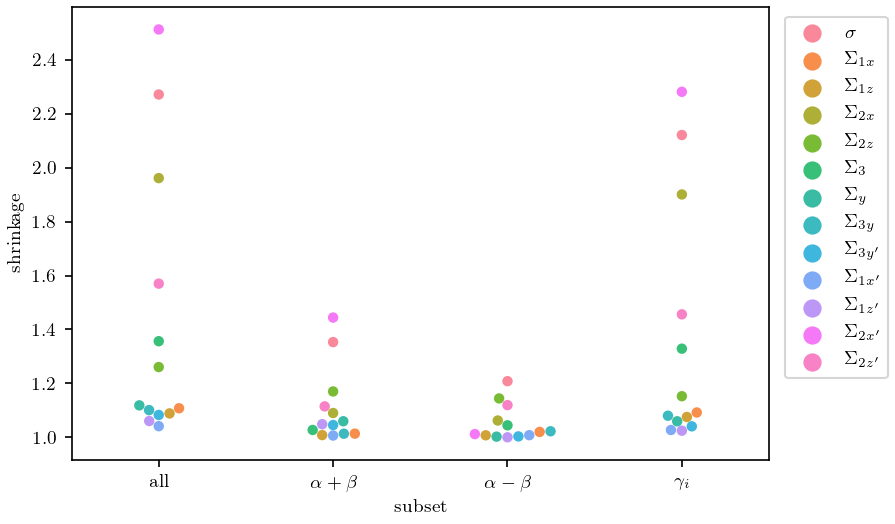

In [79]:
sns.swarmplot(
    x='subset', y='shrinkage', data=df_bests_npt_trunc[df_bests_npt_trunc['nucleon'] == 'proton'],
    hue='observable')
plt.legend().set_bbox_to_anchor((1.01, 1))

In [80]:
df_bests_join = pd.concat([df_bests_npt_trunc, df_bests_1pt_reduced_trunc], sort=False)
df_bests_join

,nucleon,observable,subset,util,idxs,omega,theta,shrinkage,n pts
0,neutron,$\Sigma_{1x'}$,all,0.030174,"[1451, 1453, 1455, 1457, 1459]","[170.0, 170.0, 170.0, 170.0, 170.0]","[40, 50, 60, 70, 80]",1.030634,5
1,neutron,$\Sigma_{1x}$,all,0.149549,"[1451, 1453, 1455, 1457, 1459]","[170.0, 170.0, 170.0, 170.0, 170.0]","[40, 50, 60, 70, 80]",1.161311,5
2,neutron,$\Sigma_{1z'}$,all,0.033435,"[1453, 1455, 1457, 1459, 1461]","[170.0, 170.0, 170.0, 170.0, 170.0]","[50, 60, 70, 80, 90]",1.034000,5
3,neutron,$\Sigma_{1z}$,all,0.089707,"[1453, 1455, 1457, 1459, 1461]","[170.0, 170.0, 170.0, 170.0, 170.0]","[50, 60, 70, 80, 90]",1.093854,5
4,neutron,$\Sigma_{2x'}$,all,0.344561,"[1118, 1120, 1122, 1124, 1126]","[148.0, 148.0, 148.0, 148.0, 148.0]","[40, 50, 60, 70, 80]",1.411370,5
...,...,...,...,...,...,...,...,...,...
99,proton,$\Sigma_{3y'}$,$\gamma_i$,0.010765,[1527],[180.0],[50],1.010823,1
100,proton,$\Sigma_{3y}$,$\gamma_i$,0.042019,[1451],[170.0],[40],1.042915,1
101,proton,$\Sigma_{3}$,$\gamma_i$,0.099040,[1268],[152.0],[50],1.104110,1
102,proton,$\Sigma_{y}$,$\gamma_i$,0.030958,[1377],[160.0],[40],1.031442,1


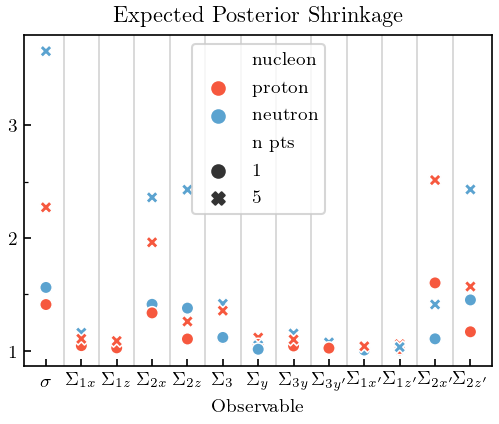

In [81]:
fig, ax = plt.subplots(figsize=(3.5, 3))

df_bests_join_all = df_bests_join[df_bests_join['subset'] == 'all']
df_bests_join_all = df_bests_join_all.sort_values(by=['observable'], ascending=True)
sns.scatterplot(
    x='observable', y='shrinkage', data=df_bests_join_all,
    hue='nucleon', style='n pts',
    palette={'neutron': neutron_color, 'proton': proton_color},
)
ax.tick_params(direction='in')
ax.set_title('Expected Posterior Shrinkage')
ax.set_ylabel('')
ax.set_xlabel('Observable')
ax.set_yticks([1, 2, 3])
ax.set_yticks([1.5, 2.5], minor=True)

ax.set_xticks(np.arange(2*len(observables_unique)-1)/2., minor=True)
ax.tick_params(direction='in', which='both')
ax.tick_params(length=0, which='minor', axis='x')
ax.grid(True, which='minor', axis='x', color='lightgrey')

fig.tight_layout()
# plt.legend().set_bbox_to_anchor((1.01, 1))
fig.savefig('shrinkage_per_observable_all_polarizabilities')

In [82]:
observables_unique

array(['$\\sigma$', '$\\Sigma_{1x}$', '$\\Sigma_{1z}$', '$\\Sigma_{2x}$',
       '$\\Sigma_{2z}$', '$\\Sigma_{3}$', '$\\Sigma_{y}$',
       '$\\Sigma_{3y}$', "$\\Sigma_{3y'}$", "$\\Sigma_{1x'}$",
       "$\\Sigma_{1z'}$", "$\\Sigma_{2x'}$", "$\\Sigma_{2z'}$"],
      dtype=object)

In [83]:
df_bests_join_all

,nucleon,observable,subset,util,idxs,omega,theta,shrinkage,n pts
64,proton,$\sigma$,all,0.820457,"[1266, 1268, 1270, 1272, 1274]","[152.0, 152.0, 152.0, 152.0, 152.0]","[40, 50, 60, 70, 80]",2.271538,5
12,neutron,$\sigma$,all,0.446156,[1007],[140.0],[40],1.562295,1
12,neutron,$\sigma$,all,1.295734,"[933, 935, 941, 951, 953]","[130.0, 130.0, 130.0, 130.0, 130.0]","[40, 50, 80, 130, 140]",3.653678,5
64,proton,$\sigma$,all,0.344173,[1266],[152.0],[40],1.410823,1
1,neutron,$\Sigma_{1x}$,all,0.048200,[1453],[170.0],[50],1.049381,1
1,neutron,$\Sigma_{1x}$,all,0.149549,"[1451, 1453, 1455, 1457, 1459]","[170.0, 170.0, 170.0, 170.0, 170.0]","[40, 50, 60, 70, 80]",1.161311,5
53,proton,$\Sigma_{1x}$,all,0.045747,[1451],[170.0],[40],1.046810,1
53,proton,$\Sigma_{1x}$,all,0.102340,"[1451, 1453, 1455, 1457, 1459]","[170.0, 170.0, 170.0, 170.0, 170.0]","[40, 50, 60, 70, 80]",1.107760,5
3,neutron,$\Sigma_{1z}$,all,0.023653,[1457],[170.0],[70],1.023935,1
3,neutron,$\Sigma_{1z}$,all,0.089707,"[1453, 1455, 1457, 1459, 1461]","[170.0, 170.0, 170.0, 170.0, 170.0]","[50, 60, 70, 80, 90]",1.093854,5


In [84]:
from compton.graphs import plot_utilities_all_observables

In [85]:
util_dict_trans_trunc_sets

{('neutron',
  "$\\Sigma_{1x'}$",
  'all'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.90809783e-07, 6.31743834e-08, 0.00000000e+00]),
 ('proton',
  "$\\Sigma_{1x'}$",
  'all'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.94337997e-07, 8.73888193e-08, 0.00000000e+00]),
 ('neutron',
  "$\\Sigma_{1x'}$",
  '$\\alpha+\\beta$'): array([0., 0., 0., ..., 0., 0., 0.]),
 ('proton',
  "$\\Sigma_{1x'}$",
  '$\\alpha+\\beta$'): array([0., 0., 0., ..., 0., 0., 0.]),
 ('neutron',
  "$\\Sigma_{1x'}$",
  '$\\alpha-\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.53661803e-10, 9.44924139e-11, 0.00000000e+00]),
 ('proton',
  "$\\Sigma_{1x'}$",
  '$\\alpha-\\beta$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.60632488e-11, 4.76058776e-12, 0.00000000e+00]),
 ('neutron',
  "$\\Sigma_{1x'}$",
  '$\\gamma_i$'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.90356122e-07, 6.3

In [86]:
bests_npt_trunc_dict

{('neutron', "$\\Sigma_{1x'}$", 'all'): {'util': 0.030173868046026286,
  'idxs': array([1451, 1453, 1455, 1457, 1459]),
  'omega': array([170., 170., 170., 170., 170.]),
  'theta': array([40, 50, 60, 70, 80])},
 ('neutron', '$\\Sigma_{1x}$', 'all'): {'util': 0.14954929234317083,
  'idxs': array([1451, 1453, 1455, 1457, 1459]),
  'omega': array([170., 170., 170., 170., 170.]),
  'theta': array([40, 50, 60, 70, 80])},
 ('neutron', "$\\Sigma_{1z'}$", 'all'): {'util': 0.0334351077613706,
  'idxs': array([1453, 1455, 1457, 1459, 1461]),
  'omega': array([170., 170., 170., 170., 170.]),
  'theta': array([50, 60, 70, 80, 90])},
 ('neutron', '$\\Sigma_{1z}$', 'all'): {'util': 0.08970727616533714,
  'idxs': array([1453, 1455, 1457, 1459, 1461]),
  'omega': array([170., 170., 170., 170., 170.]),
  'theta': array([50, 60, 70, 80, 90])},
 ('neutron', "$\\Sigma_{2x'}$", 'all'): {'util': 0.34456110830074194,
  'idxs': array([1118, 1120, 1122, 1124, 1126]),
  'omega': array([148., 148., 148., 148., 1

In [87]:
mpl.rcParams['hatch.linewidth'] = 0.5

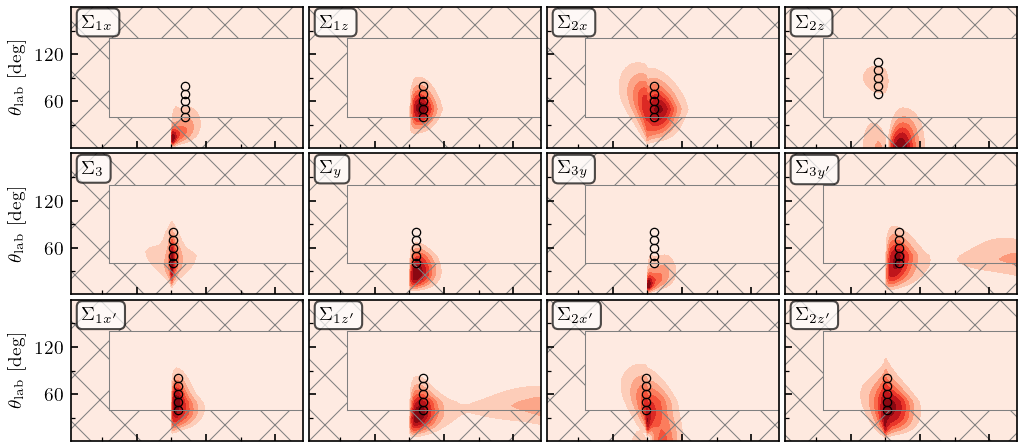

In [88]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plot_utilities_all_observables(
        util_dict_trans_trunc_sets, 'proton', 'all',
        omega_lab_unique, degrees_lab_unique, max_util_dict=bests_npt_trunc_dict,
        degrees_min=np.min(degrees_lab_reduced_unique), degrees_max=np.max(degrees_lab_reduced_unique),
        omega_min=np.min(omega_lab_reduced_unique),
        cmap='Reds',
        observables=observables_unique[1:]
    )
    for ax in axes.ravel():
        ax.set_xlabel('')
        ax.set_xticklabels([])
    plt.show()
    fig.savefig('proton_spin_grid_with_best_npts')

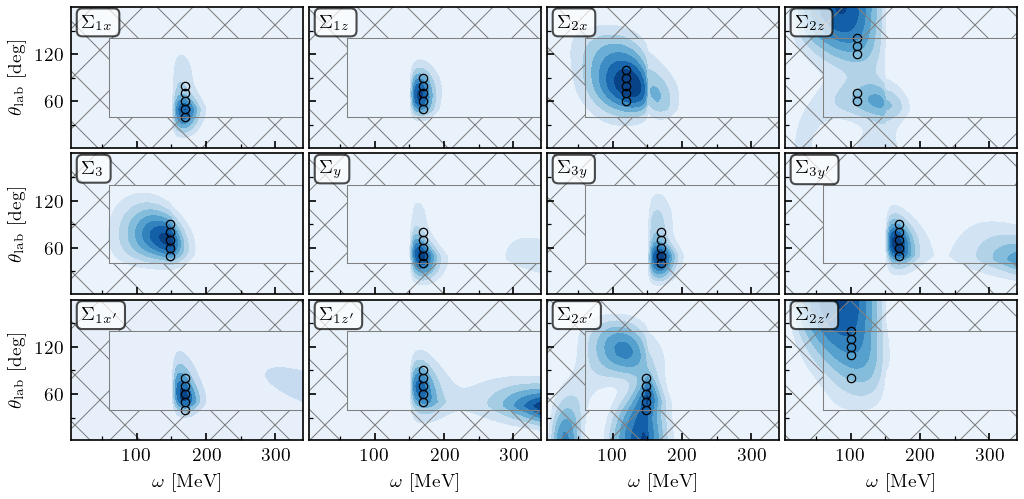

In [89]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plot_utilities_all_observables(
        util_dict_trans_trunc_sets, 'neutron', 'all',
        omega_lab_unique, degrees_lab_unique, max_util_dict=bests_npt_trunc_dict,
        degrees_min=np.min(degrees_lab_reduced_unique), degrees_max=np.max(degrees_lab_reduced_unique),
        omega_min=np.min(omega_lab_reduced_unique),
        cmap='Blues', observables=observables_unique[1:]
    )
    plt.show()
    fig.savefig('neutron_spin_grid_with_best_npts')

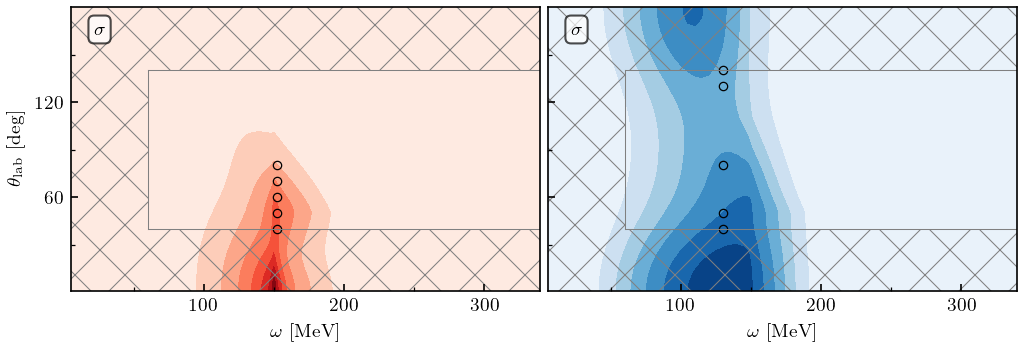

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5), sharey=True)
plot_utilities_all_observables(
    util_dict_trans_trunc_sets, 'proton', 'all',
    omega_lab_unique, degrees_lab_unique, max_util_dict=bests_npt_trunc_dict,
    degrees_min=np.min(degrees_lab_reduced_unique), degrees_max=np.max(degrees_lab_reduced_unique),
    omega_min=np.min(omega_lab_reduced_unique),
    cmap='Reds',
    axes=axes[[0]],
    observables=observables_unique[[0]]
)

plot_utilities_all_observables(
    util_dict_trans_trunc_sets, 'neutron', 'all',
    omega_lab_unique, degrees_lab_unique, max_util_dict=bests_npt_trunc_dict,
    degrees_min=np.min(degrees_lab_reduced_unique), degrees_max=np.max(degrees_lab_reduced_unique),
    omega_min=np.min(omega_lab_reduced_unique),
    cmap='Blues', observables=observables_unique[[0]],
    axes=axes[[1]],
);
axes[1].set_ylabel('')
fig.tight_layout(w_pad=0.4)
fig.savefig('dsg_grid_with_best_npts')

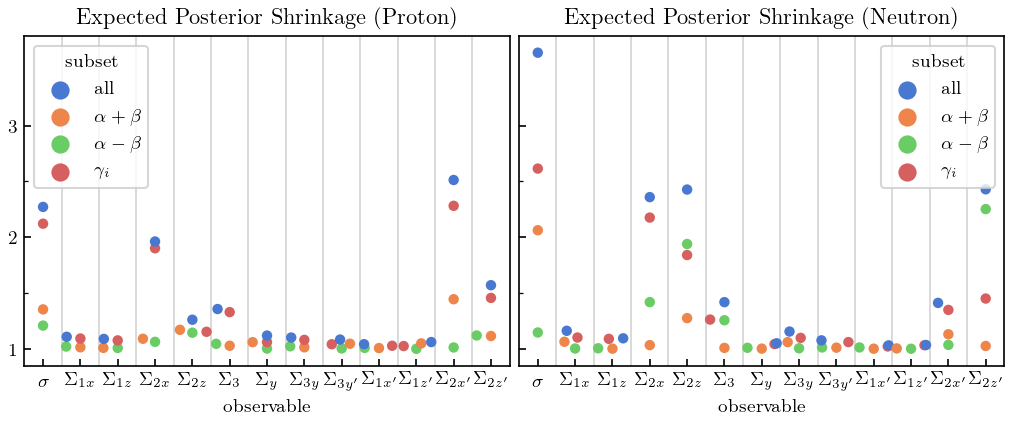

In [91]:
# sns.scatterplot(
#     x='observable', y='shrinkage', data=df_bests_npt_trunc[df_bests_npt_trunc['nucleon'] == 'proton'],
#     style='subset'
# )
fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

df_bests_npt_trunc_sort = df_bests_npt_trunc.sort_values(by=['observable'], ascending=True)

# sns.scatterplot(
#     x='observable', y='shrinkage', data=df_bests_npt_trunc_sort[df_bests_npt_trunc_sort['nucleon'] == 'proton'],
#     style='subset',
#     style_order=subset_names,
#     color=proton_color,
#     ax=axes[0]
# )

# sns.scatterplot(
#     x='observable', y='shrinkage', data=df_bests_npt_trunc_sort[df_bests_npt_trunc_sort['nucleon'] == 'neutron'],
#     style='subset',
#     style_order=subset_names,
#     color=neutron_color,
#     ax=axes[1]
# )
palette = 'muted'

sns.swarmplot(
    x='observable', y='shrinkage', data=df_bests_npt_trunc_sort[df_bests_npt_trunc_sort['nucleon'] == 'proton'],
    hue='subset',
    hue_order=subset_names,
    palette=palette,
#     color=proton_color,
    ax=axes[0]
)

sns.swarmplot(
    x='observable', y='shrinkage', data=df_bests_npt_trunc_sort[df_bests_npt_trunc_sort['nucleon'] == 'neutron'],
    hue='subset',
    hue_order=subset_names,
    palette=palette,
#     color=neutron_color,
    ax=axes[1]
)

axes[1].set_ylabel('')
axes[0].set_yticks([1, 2, 3])
axes[0].set_yticks([1.5, 2.5], minor=True)

for ax in axes:
    ax.set_xticks(np.arange(2*len(observables_unique)-1)/2., minor=True)
    ax.tick_params(direction='in', which='both')
    ax.tick_params(length=0, which='minor', axis='x')
    ax.grid(True, which='minor', axis='x', color='lightgrey')
# axes[0].set_ylabel('Expected Posterior Shrinkage')
axes[0].set_ylabel('')
axes[0].set_title('Expected Posterior Shrinkage (Proton)')
axes[1].set_title('Expected Posterior Shrinkage (Neutron)')

# axes[0].legend().set_bbox_to_anchor((0.5, 1))

fig.tight_layout(w_pad=-0.5)
fig.savefig('shrinkage_per_subset')
# plt.legend().set_bbox_to_anchor((1.01, 1))

In [92]:
from compton.graphs import plot_comparison_subsets_for_observables

In [93]:
subset_names

['all', '$\\alpha+\\beta$', '$\\alpha-\\beta$', '$\\gamma_i$']

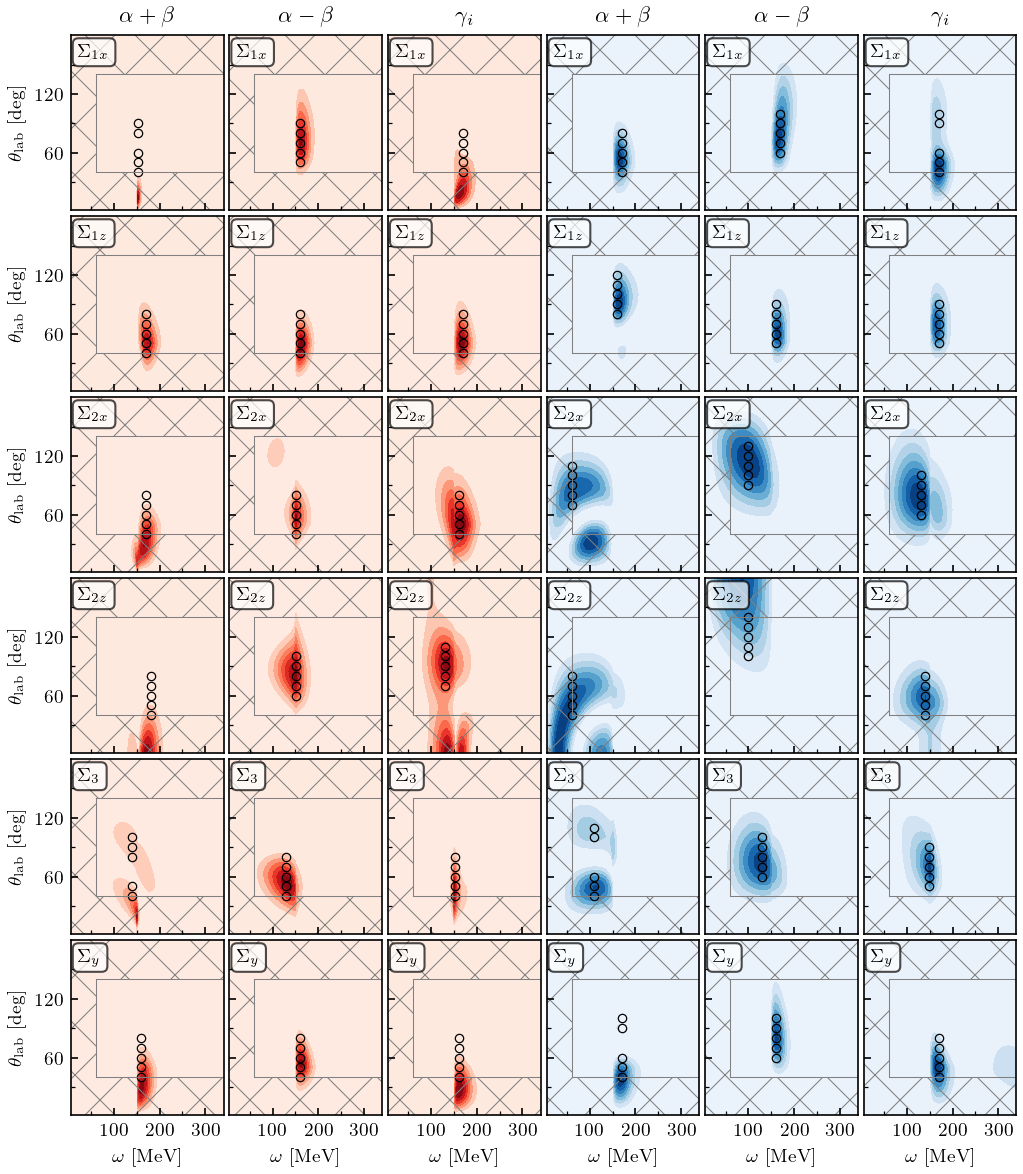

In [94]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plot_comparison_subsets_for_observables(
        util_dict_trans_trunc_sets, omega_lab_unique, degrees_lab_unique,
        max_util_dict=bests_npt_trunc_dict,
        degrees_min=np.min(degrees_lab_reduced_unique), degrees_max=np.max(degrees_lab_reduced_unique),
        omega_min=np.min(omega_lab_reduced_unique),
        cmap_p='Reds', cmap_n='Blues',
        observables=observables_unique[1:7],
        subsets=subset_names[1:]
    );
    plt.show()
    fig.savefig('utilities_for_subsets_observable_set_1')

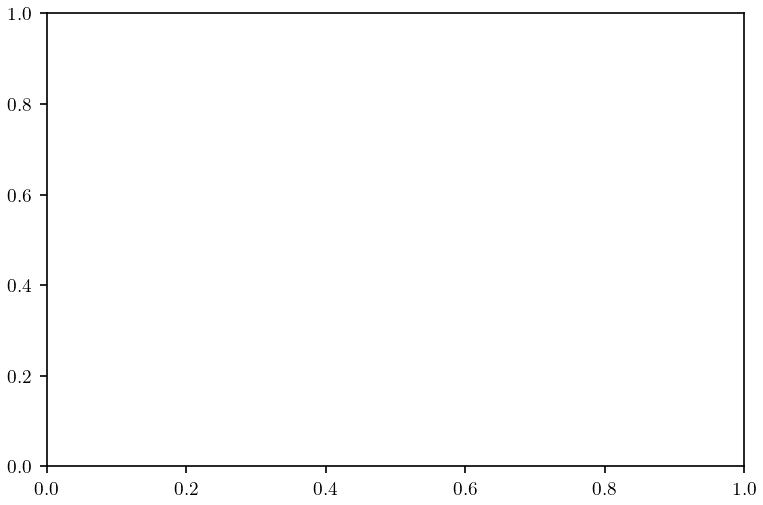

In [95]:
plt.tick_params()

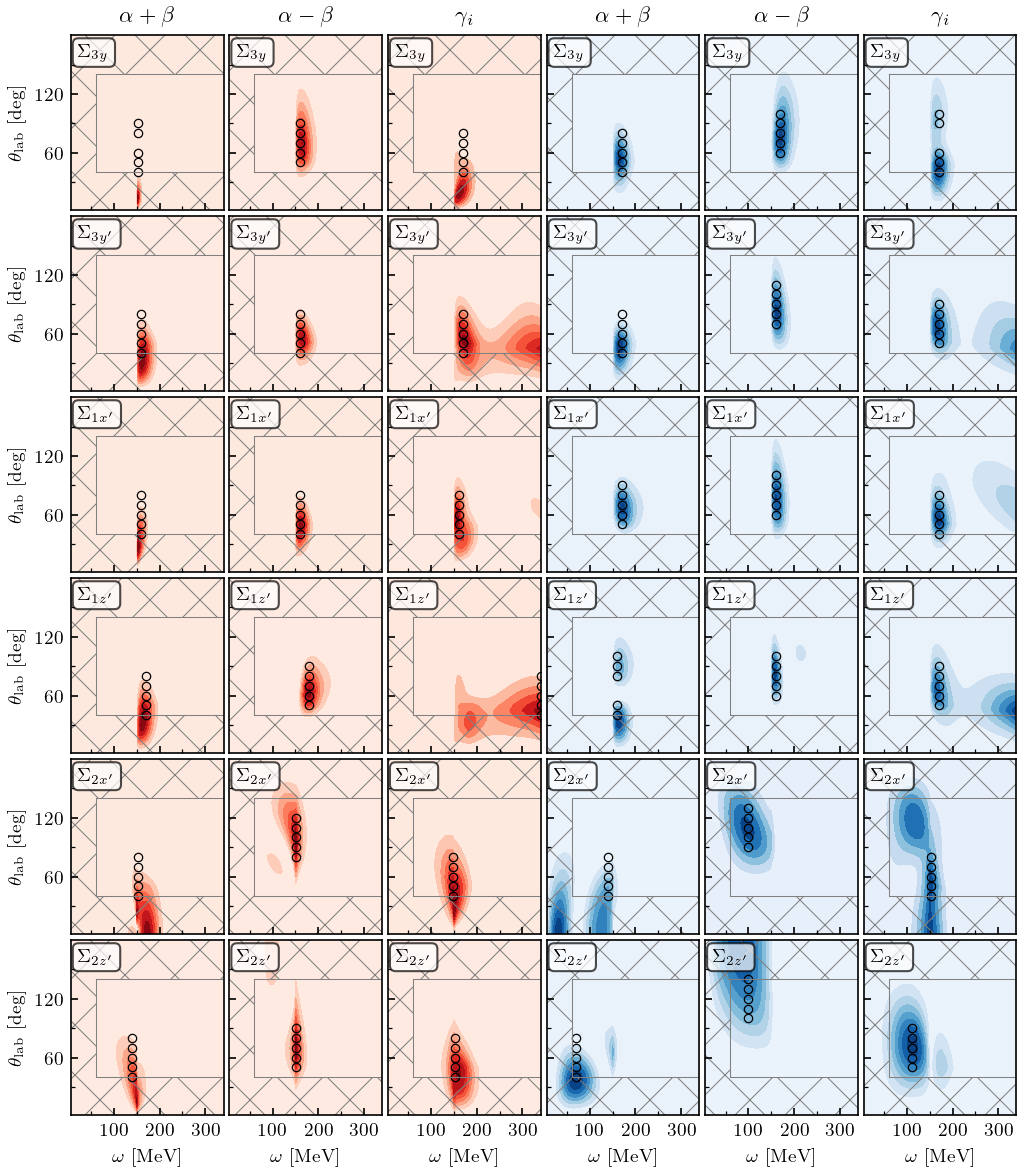

In [96]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plot_comparison_subsets_for_observables(
        util_dict_trans_trunc_sets, omega_lab_unique, degrees_lab_unique,
        max_util_dict=bests_npt_trunc_dict,
        degrees_min=np.min(degrees_lab_reduced_unique), degrees_max=np.max(degrees_lab_reduced_unique),
        omega_min=np.min(omega_lab_reduced_unique),
        cmap_p='Reds', cmap_n='Blues',
        observables=observables_unique[7:],
        subsets=subset_names[1:]
    );
    plt.show()
    fig.savefig('utilities_for_subsets_observable_set_2')

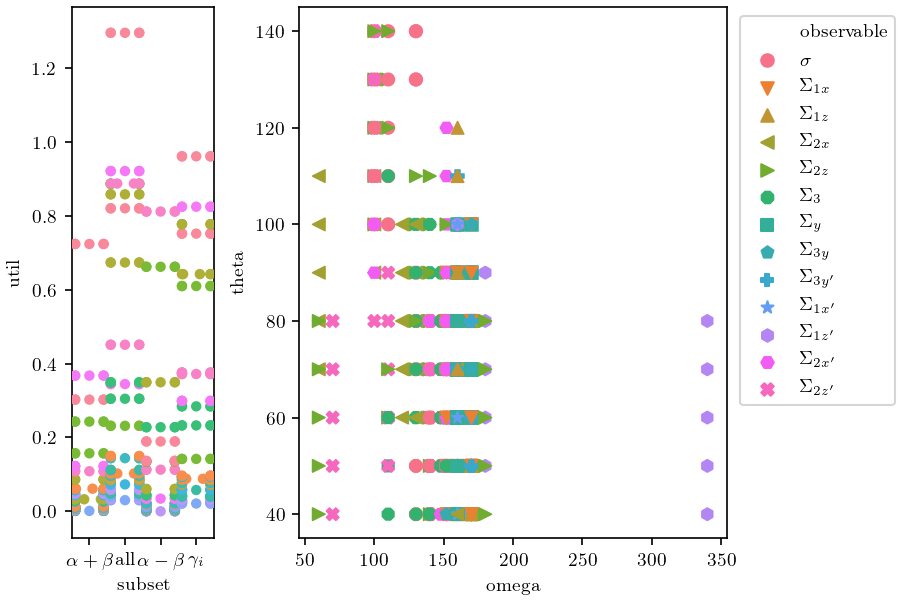

In [97]:
markers2 = ['o', 'v', '^', '<', '>', '8', 's', 'p', 'P', '*', 'h', 'H', 'X']

# fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig = plt.figure(constrained_layout=True)
gs1 = fig.add_gridspec(nrows=1, ncols=4, left=0.05, right=0.48, wspace=0.05)
ax1 = fig.add_subplot(gs1[0, 1:])
ax2 = fig.add_subplot(gs1[0, 0])

sns.scatterplot(x='omega', y='theta', data=df_bests_npt_trunc_flat, hue='observable', style='observable',
                markers=markers2, facecolor='white', edgecolor=None, ax=ax1)
sns.swarmplot(x='subset', y='util', data=df_bests_npt_trunc_flat, hue='observable', ax=ax2)

# ax1.set_title(fr'Grid Locations ($\xi =$ {subset_name})')
ax2.legend().remove()
ax1.legend().set_bbox_to_anchor((1.01, 1))
# fig.savefig(f'figures/grids_and_utilities_trunc_subset-{subset_savenames[subset_name]}.pdf')

In [98]:
markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '1', '2', '3', '4', 'P', '*']

In [99]:
plot_kwargs = {
    'crosssection': dict(fillstyle='none', marker='o'),
}

NameError: name 'bests' is not defined

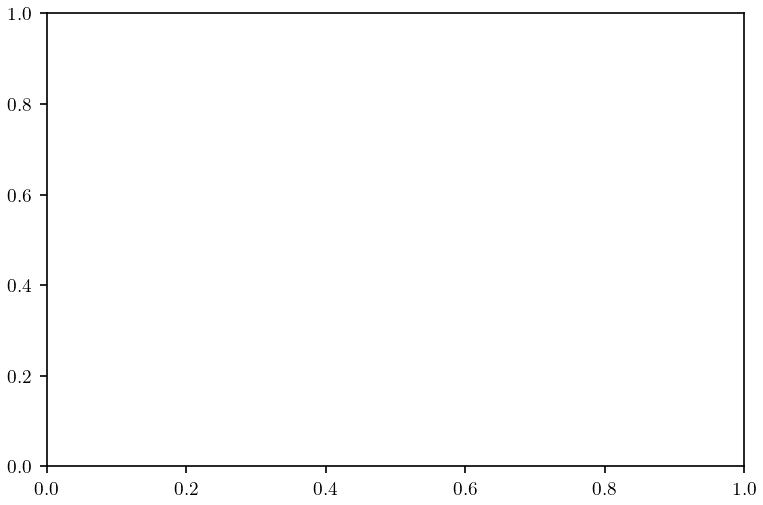

In [100]:
fig, ax = plt.subplots()
# ax.plot(X_reduced[:, 0], X_reduced[:, 1], ls='', marker=',', c='k')
for i, obs in enumerate(bests):
    ax.plot(bests[obs]['omega'], bests[obs]['theta'], ls='', marker=markers[i], fillstyle='none', label=obs)
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

In [ ]:
X_reduced[best_idxs]